# Exploring French Infringement Patent Field Through Case Decisions - 2009 to 2020

## Merging existing db(s)

In [1]:
# import all relevant librairies and dependancies
import country_converter as coco
from collections import Counter
from collections import OrderedDict, defaultdict
from numpy import percentile
from numpy import arange
from lmfit import Model
from pprint import pprint
from scipy.interpolate import make_interp_spline
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import r2_score
from statistics import mean
from tabulate import tabulate

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

# data class files
from d_second_decision import d_second
from d_third_decision import d_third

In [2]:
# import raw darts-ip dbs

final_1 = 'G:\\My Drive\\SCIENCES_PO\\PROJECT\\DATA\\DARTS-IP\\DATABASE\\INTEGRATION\\DECEMBRE\\UNIFIED_DARTS_IP_final_v8_08_02_2023.csv'
final_2 = 'G:\\My Drive\\SCIENCES_PO\\PROJECT\\DATA\\DARTS-IP\\DATABASE\\INTEGRATION\\DECEMBRE\\UNIFIED_DARTS_IP_final_coverage_08_02_2023.csv'

df_1 = pd.read_csv(final_1)
df_2 = pd.read_csv(final_2)

# add db_id
df_1['db_id'] = 'MAIN'
df_2['db_id'] = 'ADD'

df_final = pd.concat([df_1, df_2]).reset_index(drop=True)

In [3]:
# housekeeping, or delated data cleaning

remove = ['darts-234-781-E-fr.pdf', 'darts-809-066-E-en.pdf', 'darts-957-669-A-fr-2.pdf']
for k in remove:
    try:
        del d_second[k]
    except:
        pass

In [4]:
# filtering out non-infringement cases

flag_infrin_only = True
if flag_infrin_only == True:
    df_final = df_final[df_final['infring_dummy']==1].reset_index(drop=True)

In [5]:
# adding unique identifier

df_final['uid_1'] = df_final.index
df_final['uid_2'] = df_final.index


In [6]:
# checking for duplicates

def check_dup(df_final):
    """
    13 duplicates to figure out
    """

    pprint('len db_raw:{}'.format(len(list(df_final['uuid']))))
    pprint('len set db_raw:{}'.format(len(list(set(df_final['uuid'])))))

    df_final['uuid_dup'] = df_final.uuid.duplicated(keep=False)

    return df_final

df_final = check_dup(df_final)

'len db_raw:899'
'len set db_raw:888'


In [7]:
# recode winner and loser

def recode_win_los(df_final):
    """
    """
    # WINNERS AND LOSERS

    # winner_claim
    df_final['winner_claim_re'] = df_final['winner_claim']
    df_final['winner_claim_re'] = df_final['winner_claim_re'].fillna(0)
    # print(df_final.winner_claim_re.value_counts())

    # loser_claim
    df_final['loser_claim_re'] = df_final['loser_claim']
    df_final['loser_claim_re'] = df_final['loser_claim_re'].fillna(0)
    # print(df_final.loser_claim_re.value_counts())

    # winner_defen
    df_final['winner_defen_re'] = df_final['winner_defen']
    df_final['winner_defen_re'] = df_final['winner_defen_re'].fillna(0)
    # print(df_final.winner_defen_re.value_counts())

    # loser_defen
    df_final['loser_defen_re'] = df_final['loser_defen']
    df_final['loser_defen_re'] = df_final['loser_defen_re'].fillna(0)
    # print(df_final.loser_defen_re.value_counts())

    # no winner
    df_final['no_winner_re'] = df_final['no_winner']
    df_final['no_winner_re'] = df_final['no_winner'].fillna(0)
    # print(df_final.no_winner_re.value_counts())
    
    return df_final

df_final = recode_win_los(df_final)

# filter out no_winner for final analyses?


In [8]:
# control for cases with no outcome

def control_no_outcome(df_final):
    """
    41 cases with no outcome
    """

    df_final = df_final.astype({"winner_claim_re": int,
                                'loser_claim_re':int,
                                'winner_defen_re':int,
                                'loser_defen_re':int
                               })

    df_final["outcome_wenti"] = np.where((df_final["winner_claim_re"]==0) &
                                         (df_final['loser_claim_re']==0) &
                                         (df_final['winner_defen_re']==0) &
                                         (df_final['loser_defen_re']==0) &
                                         (df_final['no_winner_re']!=1), 0, 1)

    #pprint('outcome_wenti:{}'.format(df_final.outcome_wenti.value_counts()))
    #input()

    return df_final

df_final = control_no_outcome(df_final)

C:\Users\cinep\AppData\Local\Temp\ipykernel_42332\22263706.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final["outcome_wenti"] = np.where((df_final["winner_claim_re"]==0) &


In [9]:
def resize_plot(x_size, y_size):

    F = plt.gcf()
    Size = F.get_size_inches()
    F.set_size_inches(Size[0]*x_size, Size[1]*y_size, forward=True)

In [15]:
# generate trend plot for win-loss

def get_win_los(df_final, l_year):
    """
    """
    l_year = [x for x in l_year if x!='2022']

    # remove no winner cases
    df__ = df_final[df_final['no_winner_re'] == 0].reset_index(drop=True)

    # remove decisi_year == 'mia'

    # get infring_data
    df_ = df__[df__['infring_dummy'] == 1].reset_index(drop=True)
    count_infring = dict(df_.decisi_year.value_counts())
    count_infring = dict(sorted(count_infring.items()))

    df_inval = df__[df__['invalid_dummy'] == 1].reset_index(drop=True)
    count_invalid = dict(df_inval.decisi_year.value_counts())
    count_invalid = dict(sorted(count_invalid.items()))

    d = {}

    for year in l_year:
        #pprint('---------------------------------------')
        #pprint(year)

        loader = []
        df_year = df_[df_['decisi_year'] == year].reset_index(drop=True)
        #pprint("df_year: {}".format(df_year))

        x = dict(df_year.winner_claim_re.value_counts())

        loader.append([dict(df_year.winner_claim_re.value_counts()),
                       [x[1.0]/(x[1.0]+x[0.0]), 1-(x[1.0]/(x[1.0]+x[0.0]))],
                       dict(df_year.loser_claim_re.value_counts()),
                       dict(df_year.winner_defen_re.value_counts()),
                       dict(df_year.loser_defen_re.value_counts())])
        d[year] = loader

    return d, count_infring, count_invalid


d, count_infring, count_invalid = get_win_los(df_final, list(set(l_year)))


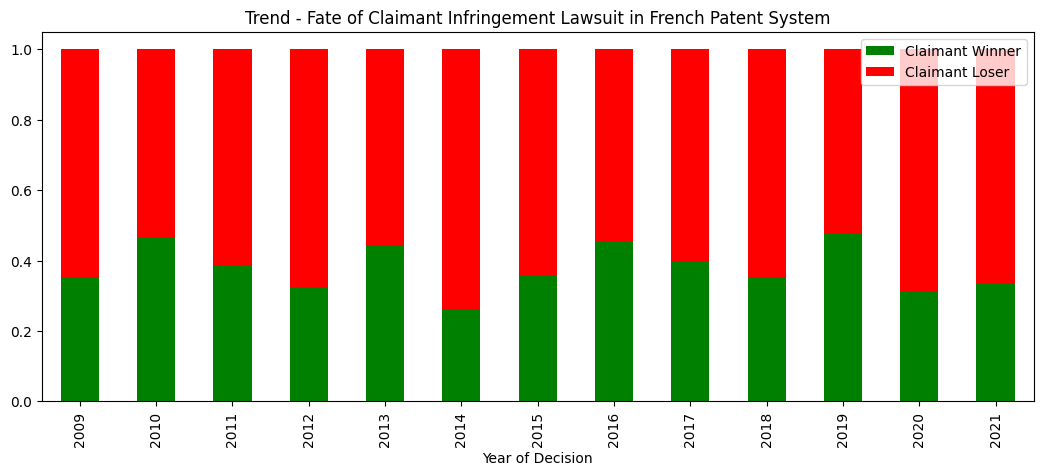

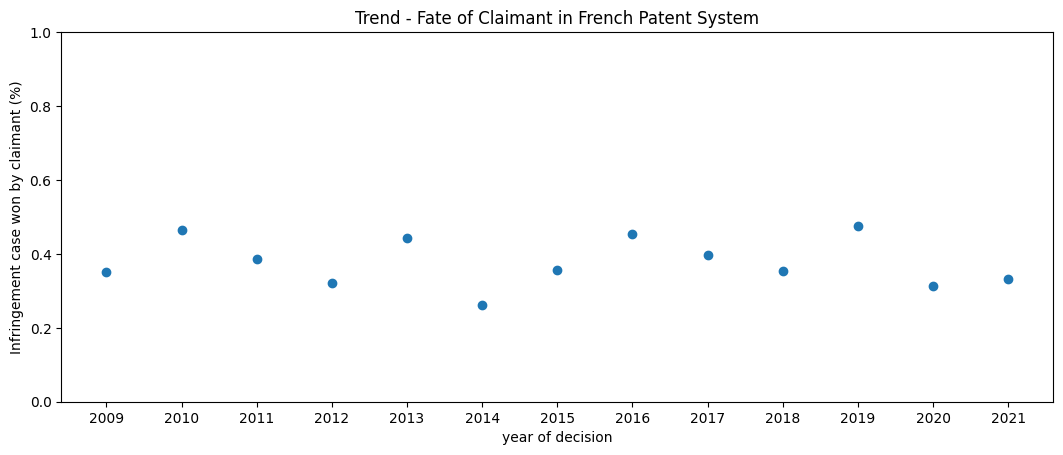

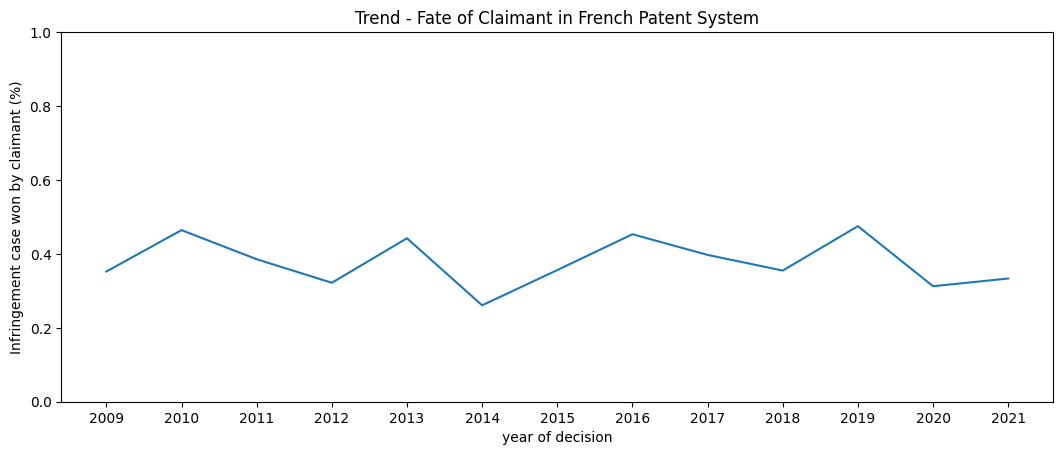

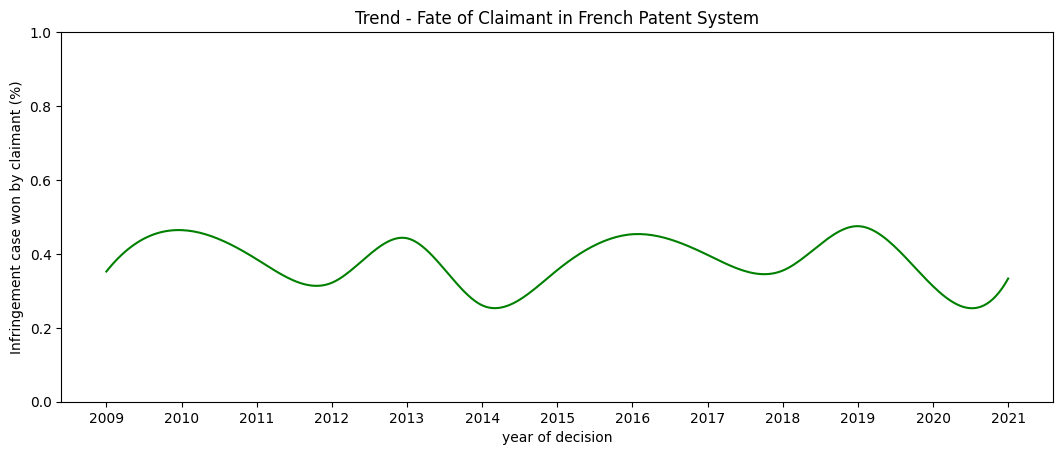

In [16]:
# (2/2)

def plot_long_win_loser(d, l_year):

    l_year = list(set(l_year))
    l_year = [x for x in l_year if x!='2022']
    l_year = sorted(l_year)

    # SHORT METHOD 2
    l_data = []
    for year in l_year:
        data = d[year]
        loser = data[0][1][1]
        winn = data[0][1][0]
        l_data.append([year, winn, loser])

    import numpy as np
    df = pd.DataFrame(l_data,
                      columns=['Year of Decision', 'Claimant Winner', 'Claimant Loser'])
    df.plot(x='Year of Decision', kind='bar', stacked=True, title='Trend - Fate of Claimant Infringement Lawsuit in French Patent System', color=['g','r'])
    resize_plot(2,1)
    plt.show()

    # scatter plot version
    l_win = [x[1] for x in l_data]
    plt.scatter(l_year, l_win)
    plt.title(f"Trend - Fate of Claimant in French Patent System")
    plt.xlabel("year of decision")
    plt.ylabel("Infringement case won by claimant (%)")
    plt.ylim(0, 1)
    resize_plot(2,1)
    plt.show()

    # line plot version
    plt.plot(l_year, l_win)
    plt.title(f"Trend - Fate of Claimant in French Patent System")
    plt.xlabel("year of decision")
    plt.ylabel("Infringement case won by claimant (%)")
    plt.ylim(0, 1)
    resize_plot(2,1)
    plt.show()

    plot_smooth_line(l_year, l_win)
    
    """"
    from scipy.optimize import curve_fit
    from lmfit import Model

    # https://stackoverflow.com/questions/59914557/sinusoidal-regression-line-with-scipy
    def sinfunc(x, a, b, c, d):
        return a * np.sin(b*(x - c)) + d

    # build model from your model function
    model  = Model(sinfunc)

    # create parameters (with initial values!)
    params = model.make_params(a=2, b=1.0, c=5.0, d=1.0)
    # you can set min/max for any parameter to put bounds on the values
    params['a'].min = 0
    params['c'].min = -np.pi
    params['c'].max = np.pi
    # do the fit to your data with those parameters
    result = model.fit(l_win, params, x=l_year)
    print(result.fit_report())
    # plot data and fit result
    plt.scatter(l_year,l_win, label='claimant win')
    plt.plot(l_year, result.best_fit, 'r-',label='Fitted function')
    plt.title(f"Trend - Fate of Claimant in French Patent System - All Instances")
    plt.xlabel("year of decision")
    plt.ylabel("Infringement case won by claimant (%)")
    plt.ylim(0, 1)
    resize_plot(2,1)
    plt.show()
    """
    
def plot_smooth_line(x, y):
    """
    """
    from scipy.interpolate import make_interp_spline

    # create integers from strings
    idx = range(len(x))
    xnew = np.linspace(min(idx), max(idx), 300)

    # interpolation
    spl = make_interp_spline(idx, y, k=3)
    smooth = spl(xnew)

    # plotting, and tick replacement
    plt.plot(xnew, smooth, '-g', label='smooooothed line')
    plt.xticks(idx, l_year)
    plt.title(f"Trend - Fate of Claimant in French Patent System")
    plt.xlabel("year of decision")
    plt.ylabel("Infringement case won by claimant (%)")
    plt.ylim(0, 1)
    resize_plot(2,1)
    plt.show()

plot_long_win_loser(d, l_year)


## INTERESTING RESULTS OF TREND ANALYSIS COULD ANCHOR THIS PAPER

The sinusoidal trend seems to be coincidantal with the rotational structure of French judges. In other words, the ups and dows are happening every 3 years. There is space in a paper to investigate whether the ebb-and-flow in the proportion of positive ruling in favor of claimants is in any way related to the rotation of judges.

Although the graphs presented above includes the rulings from the first, second, and third instances. The results for the first instance in Paris (TGI - Paris) show a very similar sinusoidal patterns. 

### Analyses to Perform

Using the data I collected on the trajectory of judges, I will try to analyse whether the sine distribution can be explained by the coming and going of new enpanneled judges. 

Also, using logistic regression, we will be able to test the hypothesis stating in France "lawyers train judges" using the delta of cases experience.

In [17]:
# DATA: recode second and third instances decisions (upheld, ...)

def add_appeal_decision(df_final, d_appeal, level):

    l_file = list(df_final.file_loc)
    l_key = list(d_appeal.keys())
    l_col = []
    for f in l_file:
        #pprint('--------------------------')
        flag_found = False
        dec = None
        for key in l_key:
            try:
                if key.lower() in f.lower():
                    #pprint(d_appeal[key])
                    dec = d_appeal[key]
                    flag_found = True
            except:
                pass
        if flag_found == True:
            l_col.append(dec)
        else:
            l_col.append(dec)

    df_final[level] = l_col
    
    if level == 'second_decision':

        # recode 1 second decision
        df_final.second_decision.value_counts()
        df_final['second_decision_re_1'] = df_final['second_decision'].apply(lambda x: 'reversed' if x == 'reversed_in_part' else x)
        df_final.second_decision_re_1.value_counts()

    if level == 'third_decision':
    
        # recode third decision
        df_final.third_decision.value_counts()
        df_final['third_decision_re_1'] = df_final['third_decision'].replace(['reversed_in_part', 'reversed_and_remand'], 'reversed')
        df_final.third_decision_re_1.value_counts()


    return df_final

df_final = add_appeal_decision(df_final, d_second, 'second_decision')
df_final = add_appeal_decision(df_final, d_third, 'third_decision')

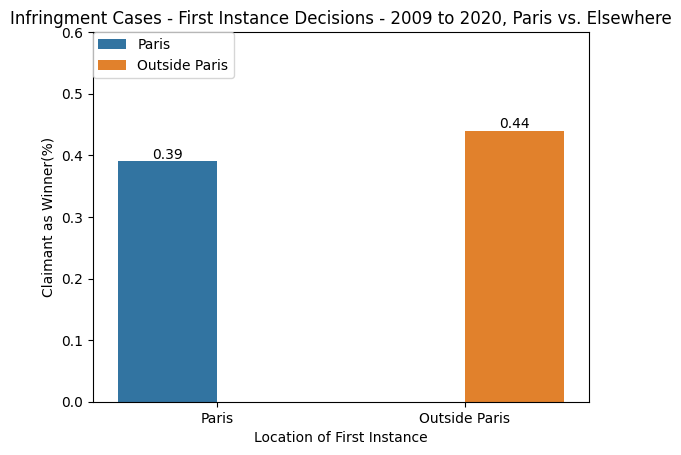

In [19]:
# compare first instances 

def plot_paris_vs(paris, not_paris, text):
    """
    """
    
    # using seaborn
    
    l_proportion = [paris, not_paris]
    l_proportion = [float(format(x, '.2f')) for x in l_proportion]
    
    data = {'first_instance':['Paris', 'Outside Paris'],
            'proportion': l_proportion
            }
    
    df = pd.DataFrame(data)
    
    ax = sns.barplot(x='first_instance', y='proportion', data=df, hue='first_instance', dodge=True)
    
    for i in ax.containers:
        ax.bar_label(i,)
    
    plt.title(f"{text} Decisions - 2009 to 2020, Paris vs. Elsewhere")
    plt.xlabel("Location of First Instance")
    plt.ylabel("Claimant as Winner(%)")
    # plt.xticks(rotation=90)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.legend(loc='upper left', borderaxespad=0)
    plt.ylim(0, 0.6)
    # resize_plot(1.5,1)
    plt.show()

#################################################################################
# first instance
#################################################################################
# BAR CHART - INSTANCES
df_final['first_instance_re'] = df_final['first_instance']
df_final['first_instance_re'] = df_final['first_instance_re'].fillna(False)
first = dict(df_final.first_instance_re.value_counts())

# GET PARIS FIRST INSTANCE
df_final['first_paris'] = np.where(df_final['first_instance_re'].str.contains('TRUE|True', na=0, case=False), 1, 0)
df_paris = df_final[df_final['first_paris']==1].reset_index(drop=True)

# TREND PARIS
d_paris, count_infring_paris, count_invalid_paris = get_win_los(df_paris, list(set(l_year)))

# OVERALL PARIS
df_paris_over = df_paris[df_paris['no_winner']!=1].reset_index(drop=True)
paris_win = df_paris_over.winner_claim.value_counts()[1]
paris_win_prop = paris_win/len(df_paris_over)
# pprint("paris_win_prop: {}".format(paris_win_prop))

# NOT PARIS
l_not_paris = ['LYON', 'STRASBOURG', 'BORDEAUX', 'MARSEILLE', 'LILLE', 'TOULOUSE', 'NANCY']
s_not_paris = '|'.join(l_not_paris)

df_final['first_not_paris'] = np.where(df_final['first_instance_re'].str.contains(s_not_paris, na=0, case=False), 1, 0)
df_not_paris = df_final[df_final['first_not_paris']==1].reset_index(drop=True)

df_not_paris_over = df_not_paris[df_not_paris['no_winner']!=1].reset_index(drop=True)
not_paris_win = df_not_paris_over.winner_claim.value_counts()[1]
not_paris_win_prop = not_paris_win/len(df_not_paris_over)
# pprint("not_paris_win_prop: {}".format(not_paris_win_prop))

plot_paris_vs(paris_win_prop, not_paris_win_prop, 'Infringment Cases - First Instance')


'paris_second_win_prop: 0.37174721189591076'
'not_paris_second_win_prop: 0.34375'


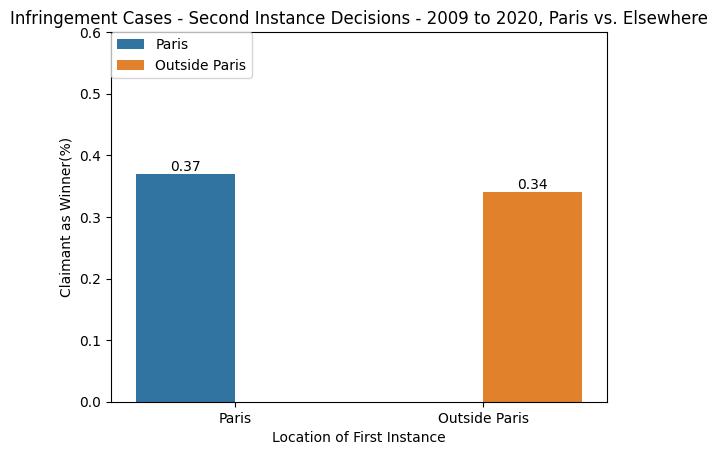

In [25]:
# compare second instances

#################################################################################
# second instance
#################################################################################
df_final['second_instance_re'] = df_final['second_instance']
df_final['second_instance_re'] = df_final['second_instance_re'].fillna(False)
second = dict(df_final.second_instance_re.value_counts())

# GET PARIS SECOND INSTANCE
df_final['second_paris'] = np.where(df_final['second_instance_re'].str.contains('TRUE|True', na=0, case=False), 1, 0)
df_paris_second = df_final[df_final['second_paris']==1].reset_index(drop=True)

# OVERALL PARIS SECOND INSTANCE
df_paris_second_over = df_paris_second[df_paris_second['no_winner']!=1].reset_index(drop=True)
paris_second_win = df_paris_second_over.winner_claim.value_counts()[1]
paris_second_win_prop = paris_second_win/len(df_paris_second_over)
pprint("paris_second_win_prop: {}".format(paris_second_win_prop))

# NOT PARIS SECOND INSTANCE
l_not_paris = ['LYON', 'STRASBOURG', 'BORDEAUX', 'MARSEILLE', 'LILLE', 'TOULOUSE', 'NANCY', 'COLMAR', 'DOUAI',
              'AIX EN PROVENCE', 'AIX-EN-PROVENCE', 'RENNES', 'ANGERS']
s_not_paris = '|'.join(l_not_paris)

df_final['second_not_paris'] = np.where(df_final['second_instance_re'].str.contains(s_not_paris, na=0, case=False), 1, 0)
df_not_paris_second = df_final[df_final['second_not_paris']==1].reset_index(drop=True)

df_not_paris_second_over = df_not_paris_second[df_not_paris_second['no_winner']!=1].reset_index(drop=True)
not_paris_second_win = df_not_paris_second_over.winner_claim.value_counts()[1]
not_paris_second_win_prop = not_paris_second_win/len(df_not_paris_second_over)
pprint("not_paris_second_win_prop: {}".format(not_paris_second_win_prop))

plot_paris_vs(paris_second_win_prop, not_paris_second_win_prop, 'Infringement Cases - Second Instance')


In [28]:
# third instance

df_final['third_instance_re'] = df_final['third_instance']
df_final['third_instance_re'] = df_final['third_instance_re'].fillna(False)
third = dict(df_final.third_instance_re.value_counts())

df_third = df_final[df_final['third_instance_re']==True].reset_index(drop=True)
df_third = df_third[df_third['no_winner']!=1].reset_index(drop=True)
third_win_prop = df_third.winner_claim.value_counts()[1]/len(df_third)
pprint(third_win_prop)

0.3829787234042553


## Please note for the previous graphs I did not perform statistics test since I am working under the assuption that I collected population data.

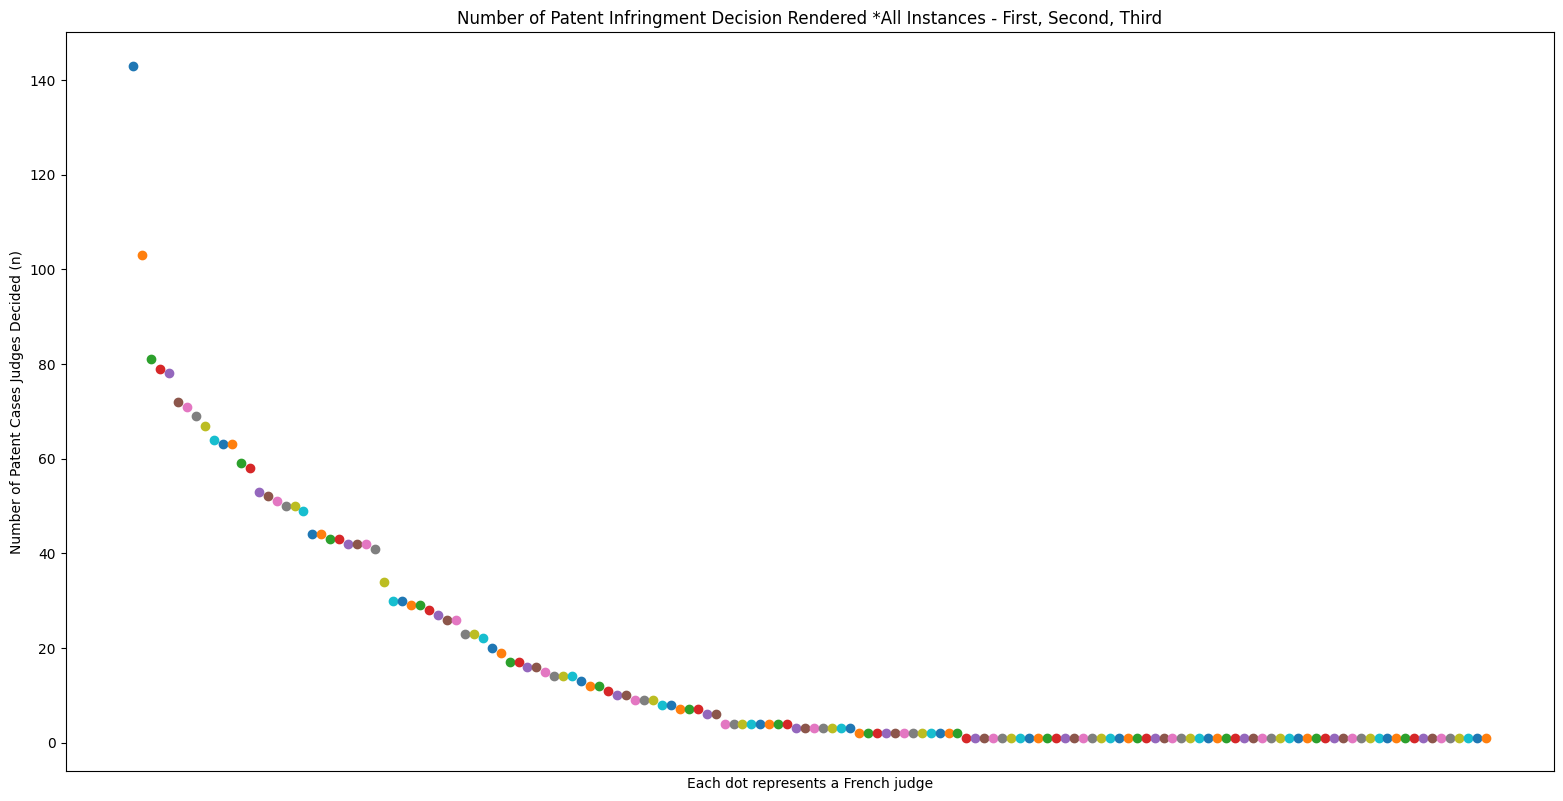

{'experience': 16, 'lose': 13, 'win': 3}
{'experience': 58, 'lose': 31, 'win': 27}
{'experience': 63, 'lose': 38, 'win': 25}
{'experience': 79, 'lose': 45, 'win': 34}
{'experience': 12, 'lose': 10, 'win': 2}
{'experience': 53, 'lose': 33, 'win': 20}
{'experience': 71, 'lose': 44, 'win': 27}
{'experience': 143, 'lose': 99, 'win': 44}
{'experience': 27, 'lose': 19, 'win': 8}
{'experience': 10, 'lose': 6, 'win': 4}
{'experience': 103, 'lose': 62, 'win': 41}
{'experience': 28, 'lose': 14, 'win': 14}
{'experience': 44, 'lose': 30, 'win': 14}
{'experience': 16, 'lose': 6, 'win': 10}
{'experience': 50, 'lose': 27, 'win': 23}
{'experience': 50, 'lose': 28, 'win': 22}
{'experience': 59, 'lose': 37, 'win': 22}
{'experience': 64, 'lose': 36, 'win': 28}
{'experience': 67, 'lose': 40, 'win': 27}
{'experience': 43, 'lose': 25, 'win': 18}
{'experience': 30, 'lose': 22, 'win': 8}
{'experience': 81, 'lose': 54, 'win': 27}
{'experience': 14, 'lose': 9, 'win': 5}
{'experience': 63, 'lose': 37, 'win': 26}

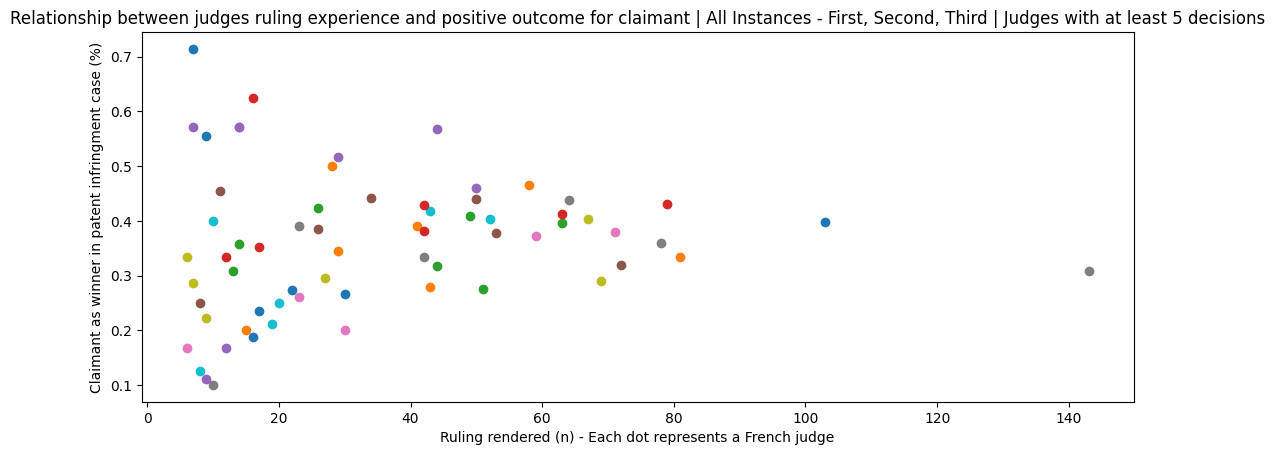

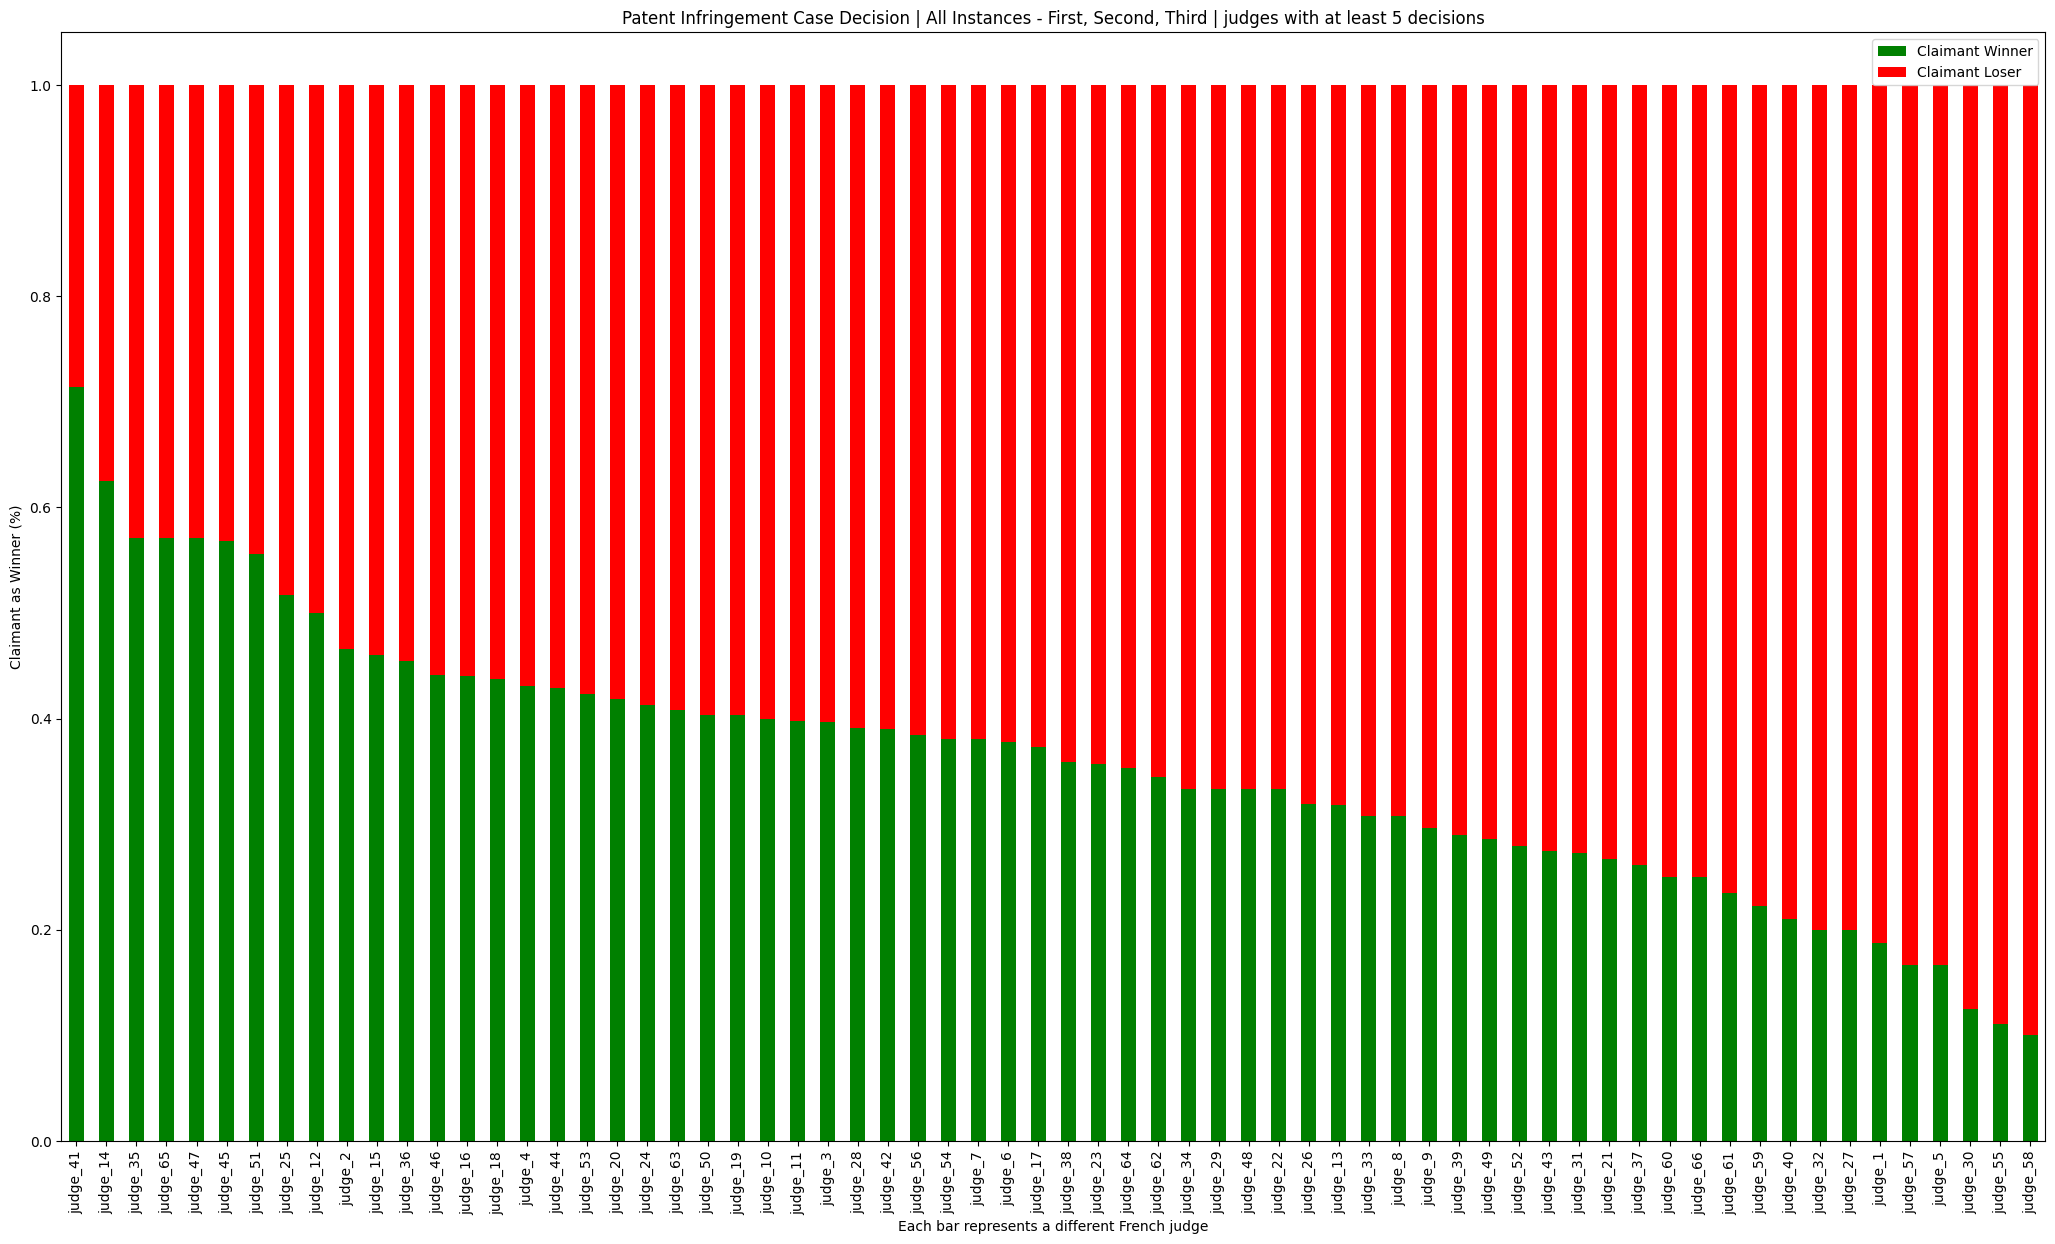

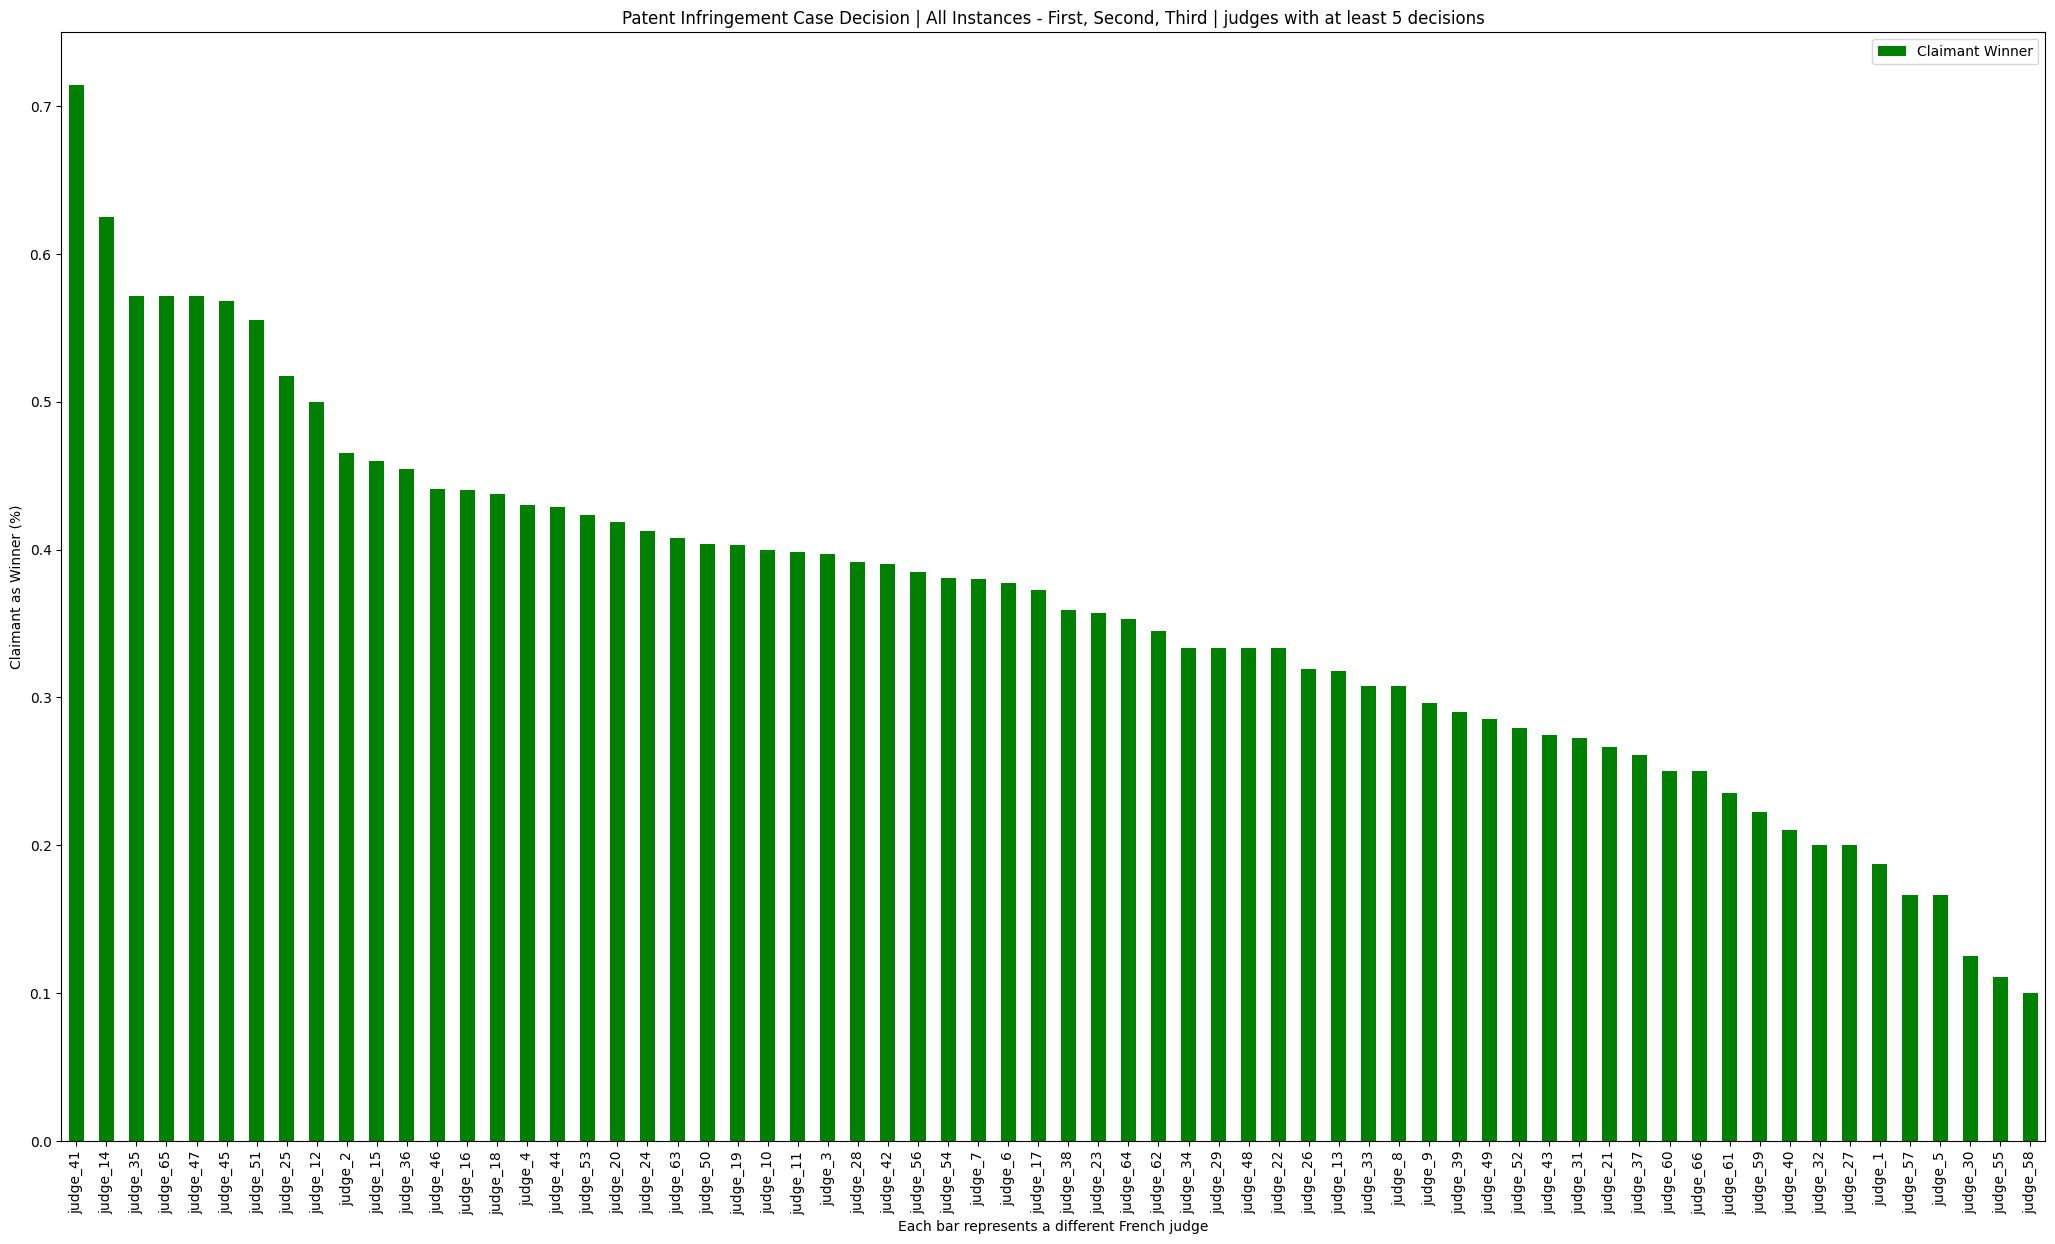

[[1.         0.95658502]
 [0.95658502 1.        ]]


In [29]:
def judges_stats(df_final, cut_off, text):
    """
    add region, paris not paris
    """
    from collections import Counter

    # cut_off = 5
    # text = 'dude'

    # number of cases overseen
    judge_1 = list(df_final['judge_cat_1'])
    judge_2 = list(df_final['judge_cat_2'])
    judge_3 = list(df_final['judge_cat_3'])
    l_judges = judge_1 + judge_2 + judge_3
    l_judges_r = [x for x in l_judges if str(x)!='nan']
    l_judges = [f'jud_{str(int(x))}' for x in l_judges_r]

    d_exp_judge = Counter(l_judges)

    # scatter plot
    l_value = sorted(list(d_exp_judge.values()), reverse=True)
    # for x, y in d_exp_judge.items():
    for i, y in enumerate(l_value):
        plt.scatter(i,y)
    plt.xticks([])
    plt.title(f"Number of Patent Infringment Decision Rendered *{text}")
    plt.xlabel("Each dot represents a French judge")
    plt.ylabel("Number of Patent Cases Judges Decided (n)")
    resize_plot(3,2)
    plt.show()

    ####################################
    # fit data
    # from scipy.optimize import curve_fit

    # def Gauss(x, A, B):
        # y = A*np.exp(-1*B*x**2)
        # return y
    # parameters, covariance = curve_fit(Gauss, xdata, ydata)

    # l_x = [x for x in range(153)]
    # l_x.pop(0)

    # xdata = np.asarray(l_x)
    # ydata = np.asarray(l_value)

    # curve = np.polyfit(xdata, ydata, 1)
    # print(curve)
    # y = curve[0]*xdata + curve[1]

    # plt.plot(xdata, y)

    # from scipy import stats
    # s, loc, scale = stats.lognorm.fit(ydata, floc=0) #x0 is rawdata x-axis
    # estimated_mu = np.log(scale)
    # estimated_sigma = s
    ####################################

    # get frequency plot
    freq_exp = list(d_exp_judge.values())
    d_freq_exp = Counter(freq_exp)
    # need to bin it

    # get winner|loser
    d_exp_judge_r = Counter(l_judges_r)
    d_jug_win = {}
    for x, y in d_exp_judge_r.items():
        if y >=cut_off:
            d_jug_win[x]=y

    l_zip_1 = list(zip(df_final['winner_claim_re'], df_final['judge_cat_1']))
    l_zip_2 = list(zip(df_final['winner_claim_re'], df_final['judge_cat_2']))
    l_zip_3 = list(zip(df_final['winner_claim_re'], df_final['judge_cat_3']))
    l_all = l_zip_1+l_zip_2+l_zip_3

    for x, y in d_jug_win.items():
        loader = {'win':0, 'lose':0, 'experience':y}
        for a in l_all:
            if a[1] == x:
                if a[0]==1:
                    loader['win']+=1
                if a[0]==0:
                    loader['lose']+=1
        d_jug_win[x] = loader
        
    #pprint(d_jug_win)
    #input()

    # plot decision of judges
    l_data = []
    for x, y in d_jug_win.items():
        pprint(y)
        loser = y['lose']/(y['lose']+y['win'])
        #pprint("loser: {}".format(loser))
        win = y['win']/(y['lose']+y['win'])
        l_data.append([x, win, loser, y['experience']])

    # scatter plot: experience vs. win rate
    l_exp_win = [[x[3], x[1]] for x in l_data]
    # l_exp_win = [[x[3], x[1]] for x in l_data if x[3]>5]
    exp = [x[0] for x in l_exp_win]
    win_rate = [x[1] for x in l_exp_win]
    # plt.scatter(exp, win_rate)
    for i, x in enumerate(exp):
        plt.scatter(x,win_rate[i])
    # plt.xticks([])
    plt.title(f"Relationship between judges ruling experience and positive outcome for claimant | {text} | Judges with at least {cut_off} decisions")
    plt.xlabel("Ruling rendered (n) - Each dot represents a French judge")
    plt.ylabel("Claimant as winner in patent infringment case (%)")
    resize_plot(2,1)
    plt.show()
    
    # fit_linear(exp, win_rate, True)
    
    df_exp = pd.DataFrame(l_exp_win,
                      columns=['experience', 'claimant winner'])
    
    import numpy as np
    data = [x[:3] for x in l_data]
    stan_ju = [f'judge_{i+1}' for i in range(len(data))]
    data = [[stan_ju[i],x[1],x[2]] for i,x in enumerate(data)]

    df = pd.DataFrame(data,
                      columns=['judge', 'Claimant Winner', 'Claimant Loser'])
    df = df.sort_values(by=['Claimant Winner'], ascending=False)
    df.plot(x='judge', kind='bar', stacked=True, title=f'Patent Infringement Case Decision | {text} | judges with at least {cut_off} decisions', color=['g','r'])
    plt.xlabel("Each bar represents a different French judge")
    plt.ylabel("Claimant as Winner (%)")
    resize_plot(4, 3)
    plt.show()

    data = [x[:2] for x in l_data]
    data = [[stan_ju[i],x[1]] for i,x in enumerate(data)]

    df = pd.DataFrame(data,
                      columns=['judge', 'Claimant Winner'])
    df = df.sort_values(by=['Claimant Winner'], ascending=False)
    df.plot(x='judge', kind='bar', stacked=False, title=f'Patent Infringement Case Decision | {text} | judges with at least {cut_off} decisions', color=['g'])
    # df.plot(x='judge', kind='bar', stacked=False, title='Trend - Fate of Claimant in French Patent System', color=['g'])
    plt.xlabel("Each bar represents a different French judge")
    plt.ylabel("Claimant as Winner (%)")
    resize_plot(4, 3)
    plt.show()

    # correlation between level of experience (or cases overseen) and win/loss ratio
    print(np.corrcoef([x[1]*x[3] for x in l_data],[x[3] for x in l_data]))

    # location of judges (paris/not_paris | first_instance/second/third)
    d_judge_loc, df_final = get_judge_loc(list(set(l_judges_r)), df_final)

    return d_judge_loc, df_final

    # visualization of temporal rotation of judges (per chamber)
    # using CIRCOS
    
def get_judge_loc(l_judges, df_final):
    """
    census fucking instances
    first = df_final.first_instance_re.value_counts()
    second = df_final.second_instance_re.value_counts()
    third = df_final.third_instance_re.value_counts()
    """

    # FIRST
    # recode ' ' as False
    df_final['first_instance_re_2'] = df_final['first_instance_re'].apply(lambda x: False if x == ' ' else x)
    # recode 'True' as Paris
    df_final['first_instance_re_2'] = df_final['first_instance_re_2'].apply(lambda x: 'PARIS' if x == 'True' else x)
    # check
    first = df_final.first_instance_re_2.value_counts()
    #pprint("first: {}".format(first))

    # SECOND
    # recode ' ' as False
    df_final['second_instance_re_2'] = df_final['second_instance_re'].apply(lambda x: False if x == ' ' else x)
    # recode 'True' as Paris
    df_final['second_instance_re_2'] = df_final['second_instance_re_2'].apply(lambda x: 'PARIS' if x == 'True' else x)
    # recode aip
    df_final['second_instance_re_2'] = df_final['second_instance_re_2'].apply(lambda x: 'AIX-EN-PROVENCE' if x == 'AIX EN PROVENCE' else x)
    # check
    second = df_final.second_instance_re_2.value_counts()
    #pprint("second: {}".format(second))

    # THIRD
    # recode 'True' as Paris
    df_final['third_instance_re_2'] = df_final['third_instance_re'].apply(lambda x: 'PARIS' if x == 'True' else x)
    # recode True as Paris
    df_final['third_instance_re_2'] = df_final['third_instance_re_2'].apply(lambda x: 'PARIS' if x == True else x)
    # check
    third = df_final.third_instance_re_2.value_counts()
    #pprint("third:{}".format(third))

    l_instance = ['first_instance_re_2',
                  'second_instance_re_2',
                  'third_instance_re_2',
                 ]

    d_judge_loc = {}
    for inst in l_instance:

        l_zip_1 = list(zip(df_final[inst], df_final['judge_cat_1']))
        l_zip_2 = list(zip(df_final[inst], df_final['judge_cat_2']))
        l_zip_3 = list(zip(df_final[inst], df_final['judge_cat_3']))

        l_all = l_zip_1 + l_zip_2 + l_zip_3

        for x in l_judges:
            flag_change = False
            loader = []
            for data in l_all:
                if data[1] == x:
                    loader.append(data[0])

            loader = check_loader(loader)

            try:
                l = d_judge_loc[x]
                l.append({inst:loader})
                d_judge_loc[x] = l
            except:
                d_judge_loc[x] = [{inst:loader}]

    return d_judge_loc, df_final

def check_loader(loader):
    """
    """
    s_loader = list(set(loader))
    if len(s_loader)==1:
        if s_loader[0]==False:
           return [False]
        elif type(s_loader[0])==str:
            return [s_loader[0]]
    else:
        s_loader = [x for x in s_loader if type(x)==str]
        return s_loader
    
def fit_linear(rx, ry, flag_out):

    import numpy as np

    # run raw
    # method 1
    x = np.array(rx)
    y = np.array(ry)
    p = np.poly1d(np.polyfit(x, y, 1))
    x_line = np.linspace(np.amin(x), np.amax(x), 200)
    plt.scatter(x, y)
    plt.plot(x_line, p(x_line), color='red')
    plt.show()

    # method 2
    import statsmodels.api as sm
    x = sm.add_constant(rx) # Adds an intercept term to the simple linear regression formula
    lin_model = sm.OLS(ry, rx)
    regr_results = lin_model.fit()
    print(regr_results.summary())

    if flag_out == True:

        # manual method
        # remove outliers
        # l_zip = list(zip(rx, ry))
        # l_zip = [x for x in l_zip if x[0]<100]
        # rx = [x[0] for x in l_zip]
        # ry = [x[1] for x in l_zip]

        # better method
        l_outlier = find_outlier(rx, ry)
        pprint("l_outlier: {}".format(l_outlier))
        # dev_log = input()

        test_out = lambda x: 'shit' if x in l_out else x

        l_data = [f'{x[0]}_{x[1]}' for x in list(zip(rx, ry))]
        l_out = [f'{int(x[0])}_{x[1]}' for x in l_outlier]

        # l_to_out = [test_out(f'{int(x[0])}_{x[1]}') for x in l_outlier]
        l_to_out = [test_out(x) for x in l_data]
        pprint('outliers removed')

        new_data = [[rx[i], ry[i]] for i,x in enumerate(l_to_out) if x!='shit']
        rx = [x[0] for x in new_data]
        ry = [x[1] for x in new_data]

        fit_linear(rx, ry, False)
        
def find_outlier(x, y):
    """
    """
    ## (row = judge), (col = experience, win_rate)
    a = np.array(list(zip(x, y)))
    mean, stdev = np.mean(a, axis=0), np.std(a, axis=0)
    outliers = ((np.abs(a[:,0] - mean[0]) > stdev[0])
                * (np.abs(a[:,1] - mean[1]) > stdev[1])
                )
    print(a[outliers])

    return a[outliers].tolist()
    
d_judge_loc, df_final = judges_stats(df_final, 5, 'All Instances - First, Second, Third')


"[Text(0, 0, '0.69'), Text(0, 0, '0.62')]"
"[Text(0, 0, '0.31'), Text(0, 0, '0.38')]"


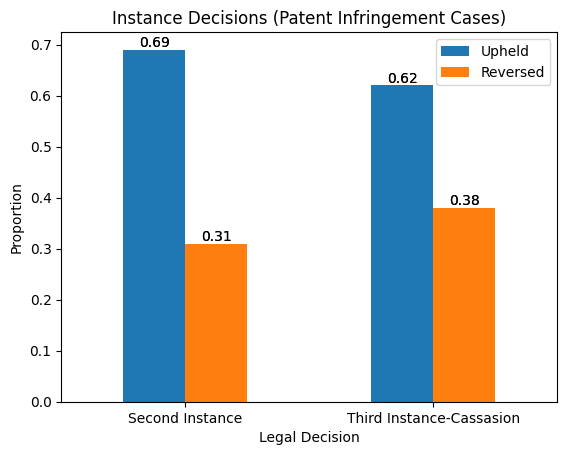

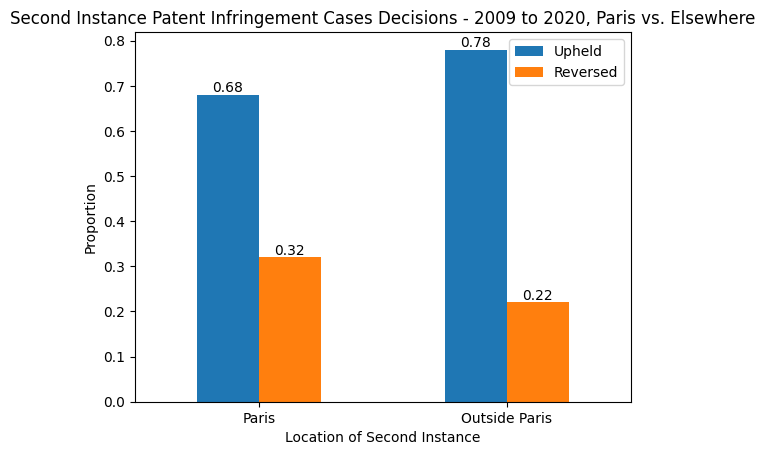

In [30]:
# plot second and third instance decisions

def plot_decisions():
    """
    any specific court(s) those decisions get reversed?
    """

    import matplotlib.pyplot as plt

    # PLOT OVERALL SECOND & THIRD DECISIONS (UPHELD vs. REVERSED)
    prop_up = [((211)/(211+52+42)), ((40)/(40+18+4+2))]
    l_up = [float(format(x, '.2f')) for x in prop_up]
    prop_re = [((52+42)/(211+52+42)), ((18+4+2)/(40+18+4+2))]
    l_re = [float(format(x, '.2f')) for x in prop_re]
    data = {'Instance':['Second Instance', 'Third Instance-Cassasion'],
            'Upheld':l_up,
            'Reversed':l_re,
            }
    df = pd.DataFrame(data)
    l_col = [x for x in list(df.columns) if x!='Instance']
    ax = df.plot(x="Instance", y=l_col, kind="bar")
    for container in ax.containers:
        ax.bar_label(container)
        pprint("{}".format(ax.bar_label(container)))
    plt.xticks(fontsize=10, rotation=360)
    plt.title("Instance Decisions (Patent Infringement Cases)")
    plt.xlabel("Legal Decision")
    plt.ylabel("Proportion")
    plt.show()
    
    # paris vs. not paris
    paris_2 = dict(df_final[df_final['second_instance_re_2']=='PARIS'].reset_index(drop=True)['second_decision_re_1'].value_counts())
    not_paris_2 = dict(df_final[df_final['second_not_paris']==1].reset_index(drop=True)['second_decision_re_1'].value_counts())
    
    test_float = lambda x: float(format(x, '.2f')) if type(x) != str else None

    l_up = [paris_2['upheld']/sum(paris_2.values()), not_paris_2['upheld']/sum(not_paris_2.values())]
    l_up = [test_float(x) for x in l_up]

    l_re = [paris_2['reversed']/sum(paris_2.values()), not_paris_2['reversed']/sum(not_paris_2.values())]
    l_re = [test_float(x) for x in l_re]

    # second instance

    data = {'Second Instance':['Paris', 'Outside Paris'],
            'Upheld':l_up,
            'Reversed':l_re,
            }
    df = pd.DataFrame(data)
    l_col = [x for x in list(df.columns) if x!='Second Instance']
    ax = df.plot(x="Second Instance", y=l_col, kind="bar")
    for container in ax.containers:
        ax.bar_label(container)
    plt.xticks(fontsize=10, rotation=360)
    plt.title("Second Instance Patent Infringement Cases Decisions - 2009 to 2020, Paris vs. Elsewhere")
    plt.xlabel("Location of Second Instance")
    plt.ylabel("Proportion")
    plt.show()


plot_decisions()


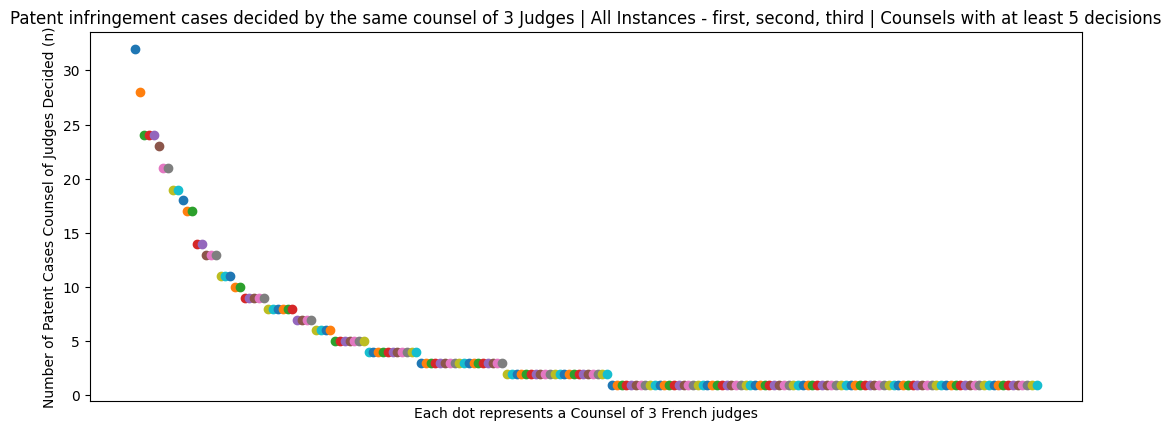

{'experience': 6, 'lose': 2, 'win': 4}
{'experience': 9, 'lose': 5, 'win': 4}
{'experience': 14, 'lose': 8, 'win': 6}
{'experience': 24, 'lose': 15, 'win': 9}
{'experience': 10, 'lose': 7, 'win': 3}
{'experience': 18, 'lose': 9, 'win': 9}
{'experience': 19, 'lose': 15, 'win': 4}
{'experience': 17, 'lose': 10, 'win': 7}
{'experience': 13, 'lose': 7, 'win': 6}
{'experience': 8, 'lose': 4, 'win': 4}
{'experience': 19, 'lose': 14, 'win': 5}
{'experience': 24, 'lose': 12, 'win': 12}
{'experience': 14, 'lose': 8, 'win': 6}
{'experience': 11, 'lose': 9, 'win': 2}
{'experience': 11, 'lose': 8, 'win': 3}
{'experience': 24, 'lose': 11, 'win': 13}
{'experience': 9, 'lose': 4, 'win': 5}
{'experience': 11, 'lose': 10, 'win': 1}
{'experience': 9, 'lose': 3, 'win': 6}
{'experience': 8, 'lose': 5, 'win': 3}
{'experience': 13, 'lose': 6, 'win': 7}
{'experience': 13, 'lose': 10, 'win': 3}
{'experience': 21, 'lose': 12, 'win': 9}
{'experience': 5, 'lose': 4, 'win': 1}
{'experience': 8, 'lose': 5, 'win': 

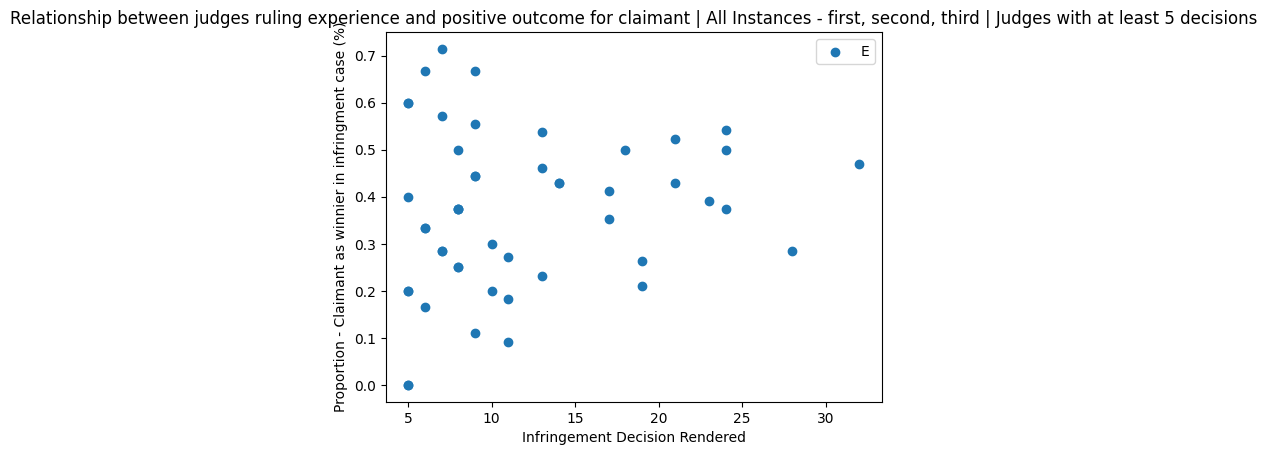

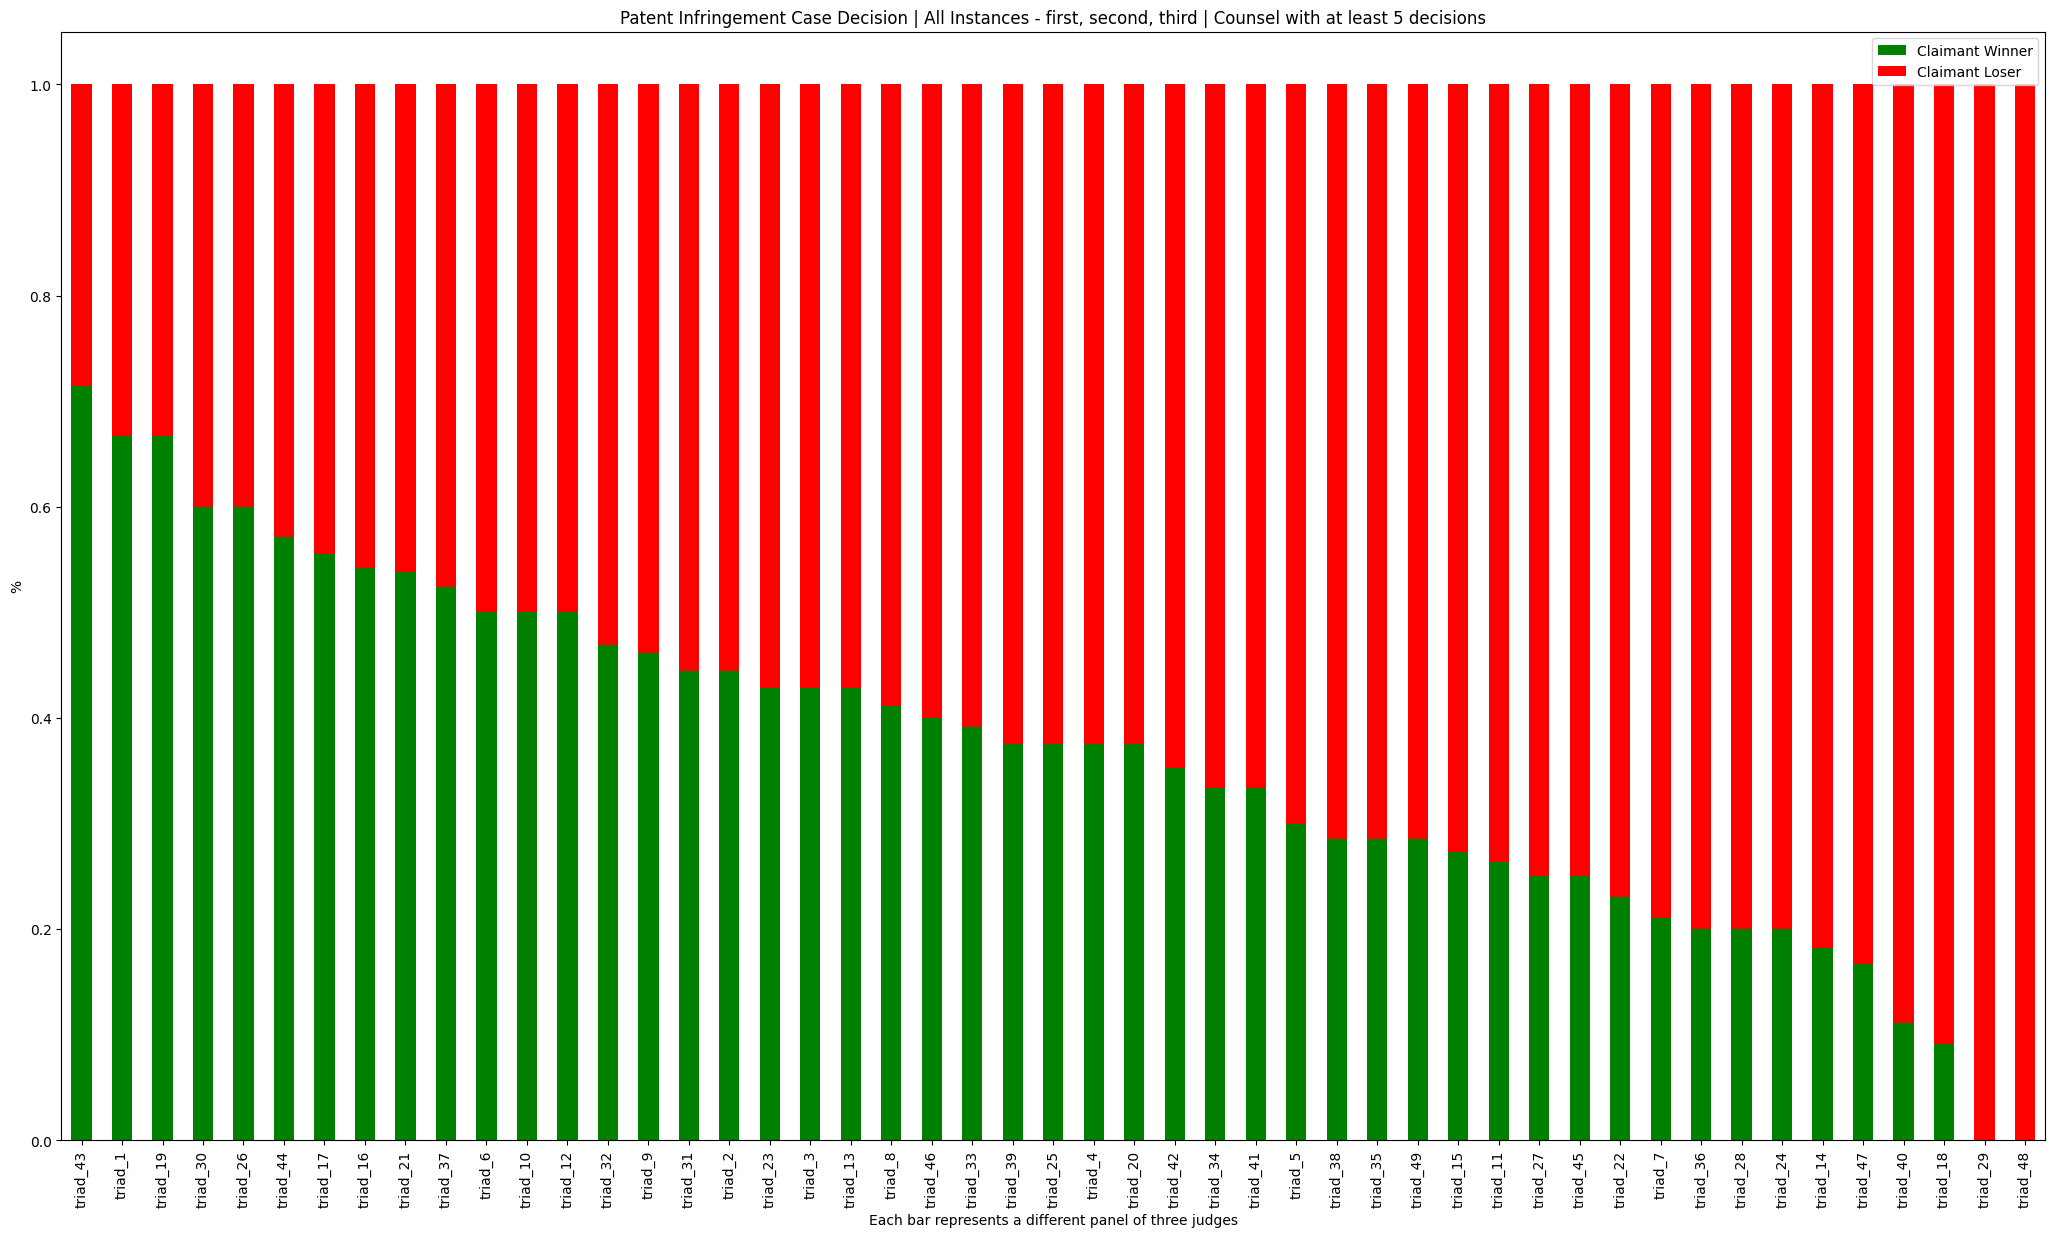

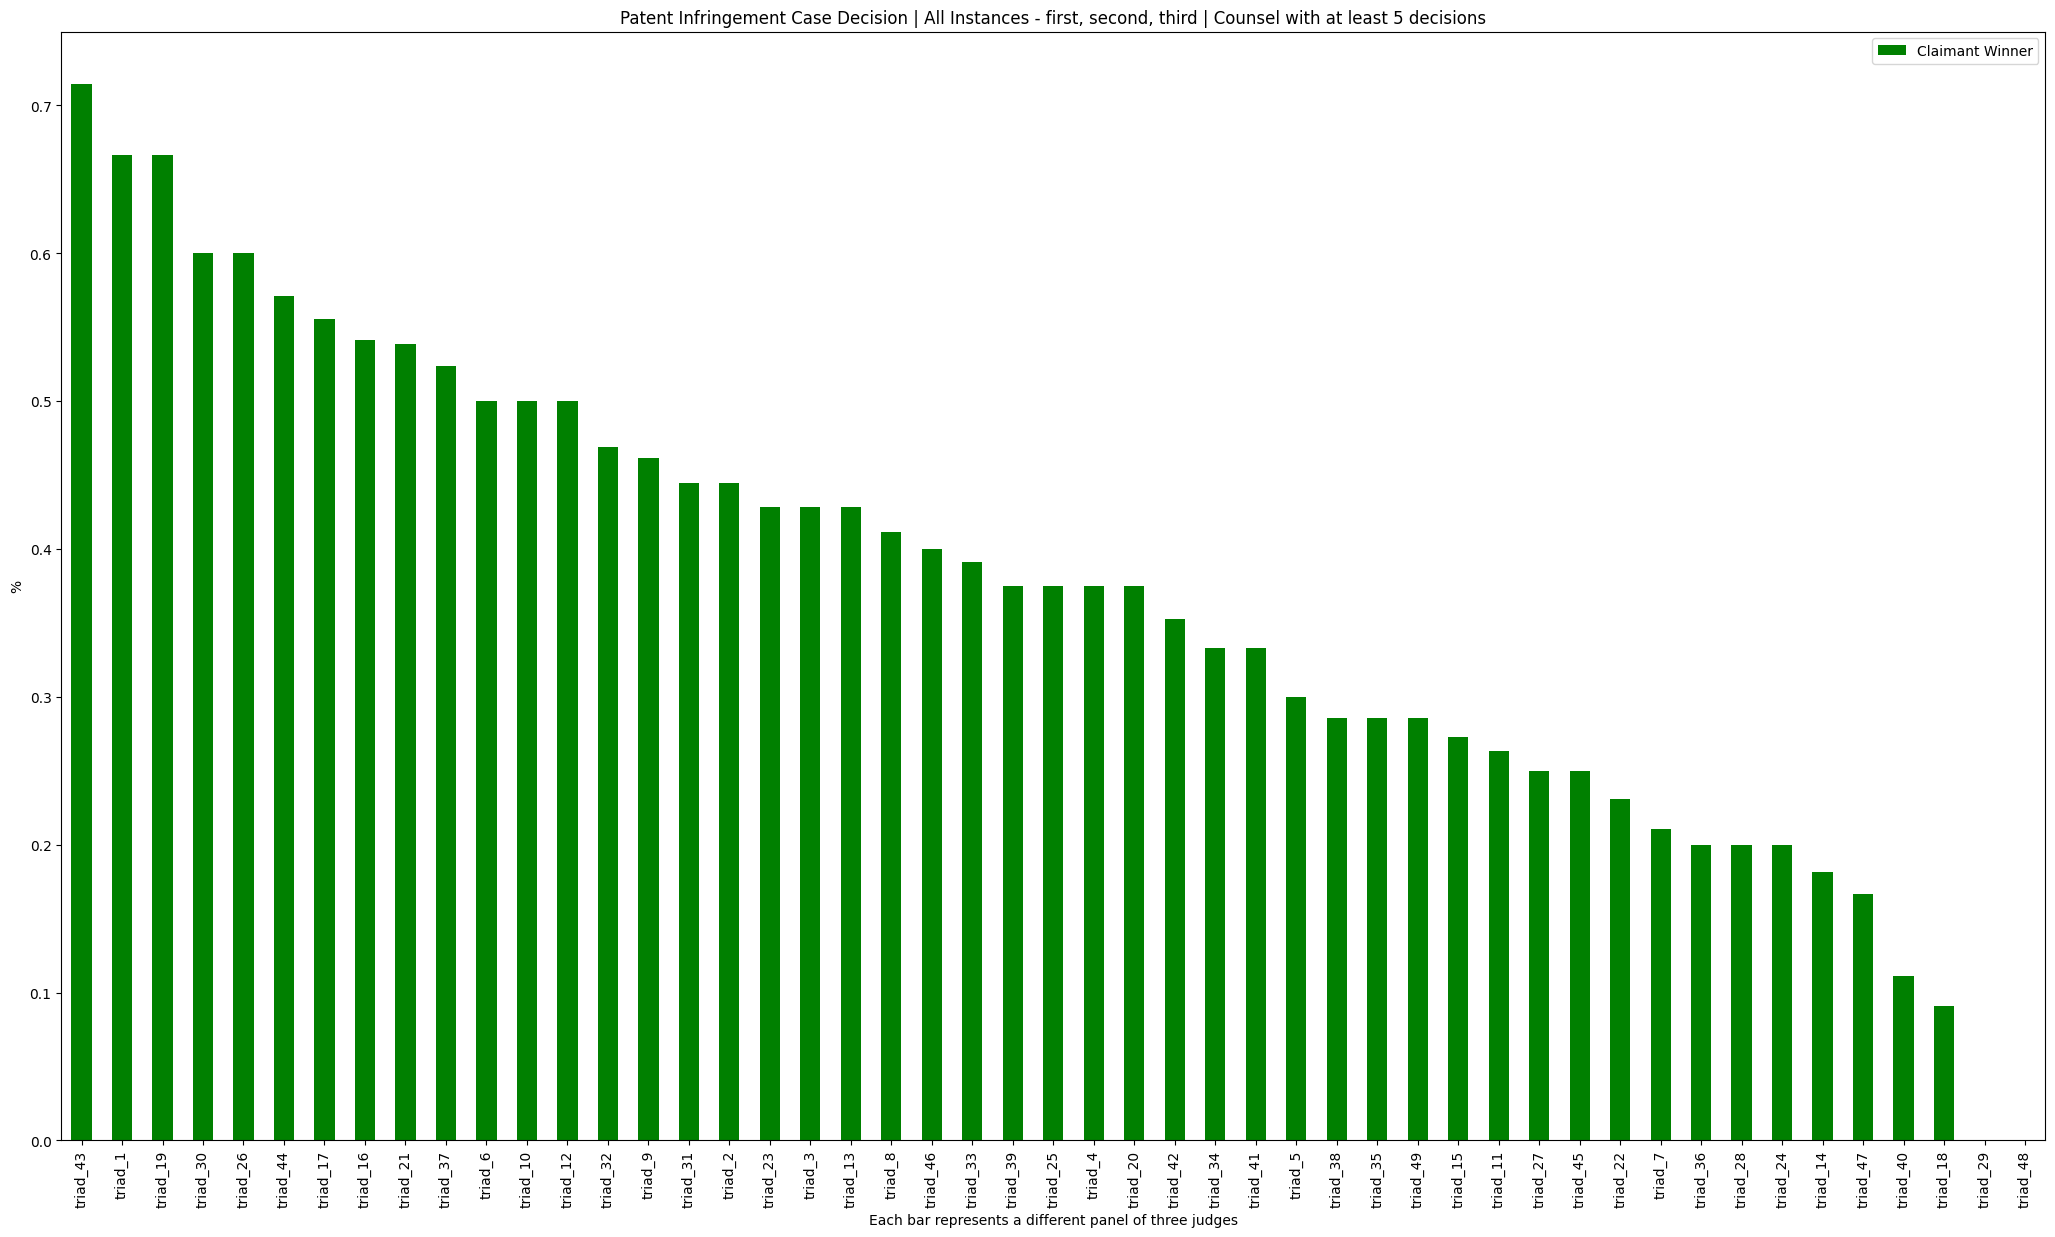

[[1.         0.87545177]
 [0.87545177 1.        ]]


In [33]:
# triad of judges

def judges_stats_abstract(df_final, cut_off, text):
    """
    level of analysis: judge
    level of analysis: case, or counsel of judges
    """
    # cut_off = 5
    # text = 'dude'

    from collections import Counter

    # number of cases overseen
    judge_1 = list(df_final['judge_cat_1'])
    judge_2 = list(df_final['judge_cat_2'])
    judge_3 = list(df_final['judge_cat_3'])
    l_judges = list(zip(judge_1, judge_2, judge_3))

    test_nan = lambda x: (888.0,) if 'nan' in str(x) else x
    l_judges_r = [test_nan(x) for x in l_judges]

    # l_judges_r = [x for x in l_judges if 'nan' not in str(x)]
    # l_judges_r = [''.join(sorted(x)) for x in l_judges_r]

    test_str = lambda x: ''.join([str(a) for a in x]) if type(x)==tuple else None
    l_judges_r = [test_str(x) for x in l_judges_r]

    df_final['triad'] = l_judges_r

    d_triad_counsel = Counter(l_judges_r)
    del d_triad_counsel['888.0']

    # scatter plot
    l_value = sorted(list(d_triad_counsel.values()), reverse=True)
    # for x, y in d_exp_judge.items():
    # for x, y in d_triad_counsel.items():
    for i, y in enumerate(l_value):
        plt.scatter(i,y)
    plt.xticks([])
    plt.title(f"Patent infringement cases decided by the same counsel of 3 Judges | {text} | Counsels with at least {cut_off} decisions")
    plt.xlabel("Each dot represents a Counsel of 3 French judges")
    plt.ylabel("Number of Patent Cases Counsel of Judges Decided (n)")
    resize_plot(2,1)
    plt.show()

    # get winner|loser
    d_counsel_win = {}
    for x, y in d_triad_counsel.items():
        if y >=cut_off:
            d_counsel_win[x]=y

    l_all = list(zip(df_final['winner_claim_re'], df_final['triad']))

    for x, y in d_counsel_win.items():
        loader = {'win':0, 'lose':0, 'experience':y}
        for a in l_all:
            if a[1] == x:
                if a[0]==1:
                    loader['win']+=1
                if a[0]==0:
                    loader['lose']+=1
        d_counsel_win[x] = loader

    # plot decision of judges
    l_data = []
    for x, y in d_counsel_win.items():
        pprint(y)
        loser = y['lose']/(y['lose']+y['win'])
        # pprint("loser: {}".format(loser))
        win = y['win']/(y['lose']+y['win'])
        l_data.append([x, win, loser, y['experience']])

    # scatter plot: experience vs. win rate
    # l_exp_win = [[x[3], x[1]] for x in l_data if x[3]>5]
    l_exp_win = [[x[3], x[1]] for x in l_data]
    exp = [x[0] for x in l_exp_win]
    win_rate = [x[1] for x in l_exp_win]
    df_out = pd.DataFrame(list(zip(exp, win_rate)),
                      columns=['experience', 'win'])
    df_out.to_csv('exp_win.csv', index=False)

    # fit_linear(exp, win_rate, True)
    
    # fitting_curve(exp, win_rate)

    plt.scatter(exp, win_rate)
    plt.title(f"Relationship between judges ruling experience and positive outcome for claimant | {text} | Judges with at least {cut_off} decisions")
    plt.legend("Each dot represents a French judge")
    plt.xlabel("Infringement Decision Rendered")
    plt.ylabel("Proportion - Claimant as winnier in infringment case (%)")
    plt.show()
    
    """
    # curve fit
    from scipy.optimize import curve_fit
    # define the true objective function
    def objective(x, a, b):
        return a * x + b
    popt, _ = curve_fit(objective, exp, win_rate)
    # summarize the parameter values
    a, b = popt
    print('y = %.5f * x + %.5f' % (a, b))
    # define a sequence of inputs between the smallest and largest known inputs
    from numpy import arange
    x_line = arange(min(exp), max(exp), 1)
    # calculate the output for the range
    y_line = objective(x_line, a, b)
    # create a line plot for the mapping function
    from matplotlib import pyplot
    import numpy as np
    pyplot.plot(x_line, y_line, '--', color='red')
    # corr_matrix = np.corrcoef(exp, x_line)
    # corr = corr_matrix[0,1]
    # R_sq = corr**2
    # print(R_sq)
    ##plt.show()
    """

    data = [x[:3] for x in l_data]
    stan_ju = [f'triad_{i+1}' for i in range(len(data))]
    data = [[stan_ju[i],x[1],x[2]] for i,x in enumerate(data)]
    
    df = pd.DataFrame(data,
                      columns=['Counsel', 'Claimant Winner', 'Claimant Loser'])
    df = df.sort_values(by=['Claimant Winner'], ascending=False)
    df.plot(x='Counsel', kind='bar', stacked=True, title=f'Patent Infringement Case Decision | {text} | Counsel with at least {cut_off} decisions', color=['g','r'])
    plt.xlabel("Each bar represents a different panel of three judges")
    plt.ylabel("%")
    resize_plot(4, 3)
    plt.show()

    data = [x[:2] for x in l_data]
    data = [[stan_ju[i],x[1]] for i,x in enumerate(data)]
    
    df = pd.DataFrame(data,
                      columns=['Counsel', 'Claimant Winner'])
    df = df.sort_values(by=['Claimant Winner'], ascending=False)
    df.plot(x='Counsel', kind='bar', stacked=False, title=f'Patent Infringement Case Decision | {text} | Counsel with at least {cut_off} decisions', color=['g'])
    plt.xlabel("Each bar represents a different panel of three judges")
    plt.ylabel("%")
    resize_plot(4, 3)
    plt.show()

    # correlation between level of experience (or cases overseen) and win/loss ratio
    print(np.corrcoef([x[1]*x[3] for x in l_data],[x[3] for x in l_data
                                                  ]))
    
def fitting_curve(exp, win_rate):
    """
    """
    x = np.array(exp)
    y = np.array(win_rate)

    from sklearn.metrics import r2_score
    from scipy import stats

    #creating OLS regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    def linefitline(b):
        return intercept + slope * b
    line1 = linefitline(x)

    #plot line
    plt.scatter(x,y)
    plt.plot(x,line1, c = 'g')
    plt.show()

    pprint('p_value:{}'.format(p_value))
    pprint('r_value:{}'.format(r_value))

judges_stats_abstract(df_final, 5, 'All Instances - first, second, third')


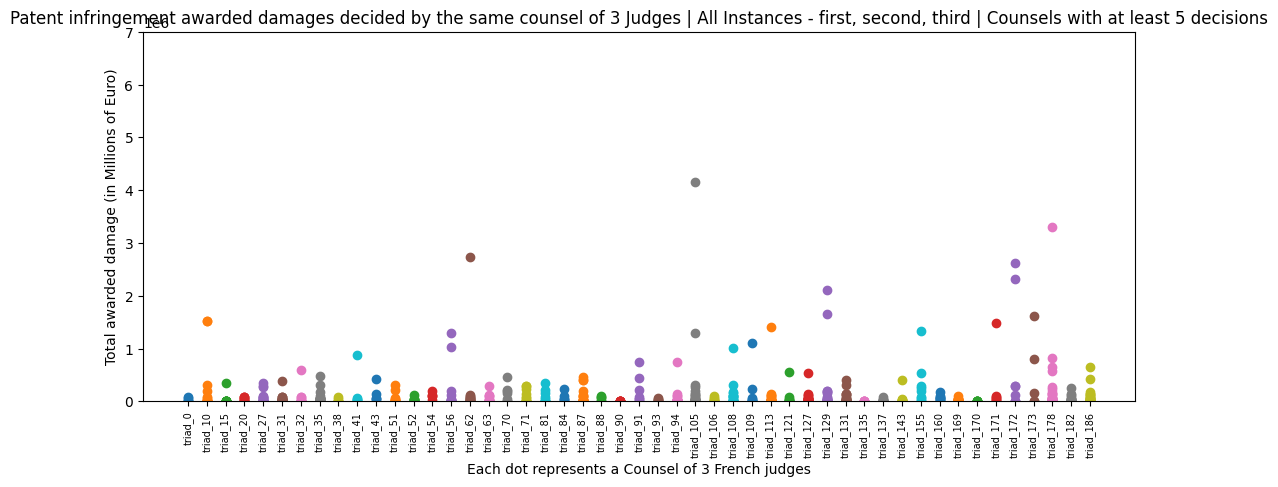

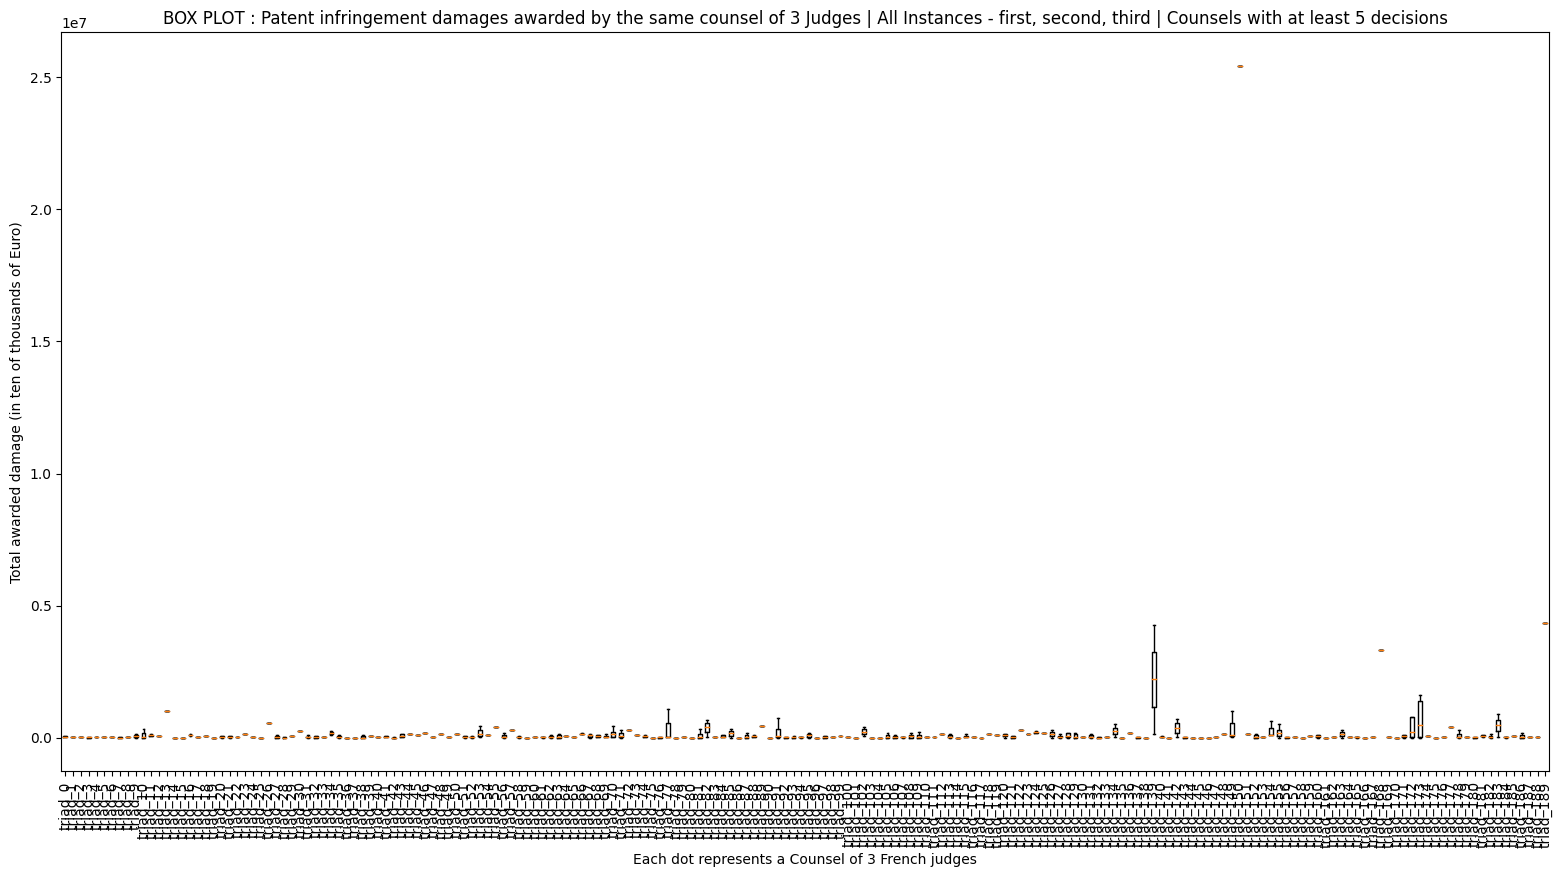

In [35]:
# cross: damages awarded by triad of judges

def counsel_damages(df_final, text, cut_off):
    """
    triad
    damages_tot
    # text = 'dude'
    # cut_off = 5
    """

    df_triad = df_final[df_final['triad']!='888.0'].reset_index(drop=True)

    l_zip = list(zip(df_triad['triad'], df_triad['damages_tot']))

    l_unique_triad = list(set(df_triad['triad']))

    d_target = {}
    for triad in l_unique_triad:
        l_ = [z[1] for z in l_zip if z[0]==triad]
        #if len(l_)>10:
        d_target[triad] = l_

    for i,d in enumerate(d_target.items()):
        k,v = d
        # pprint(k)
        # pprint(v)
        if len(v)>=cut_off:
            k_ = [f'triad_{i}' for x in range(len(v))]
            # k_ = [i for x in range(len(v))]
            plt.scatter(k_,v)
    plt.xticks(fontsize=7, rotation=90)
    plt.ylim(0, 7000000)
    plt.title(f"Patent infringement awarded damages decided by the same counsel of 3 Judges | {text} | Counsels with at least {cut_off} decisions")
    plt.xlabel("Each dot represents a Counsel of 3 French judges")
    plt.ylabel("Total awarded damage (in Millions of Euro)")
    resize_plot(2, 1)
    plt.show()

    # box plot - damages per triad
    #data = []
    #for i,d in enumerate(d_target.items()):
    #    k,v = d
    #    # pprint(k)
    #    # pprint(v)
    #    data.append(v)
    #fig = plt.figure(figsize =(10, 7))
    #ax = fig.add_axes([0, 0, 1, 1])
    #bp = ax.boxplot(data)
    #plt.show()

    fig, ax = plt.subplots()
    # ax.boxplot(d_target.values(), 0, 'gD')
    ax.boxplot(d_target.values(), 0, '')
    ax.set_xticklabels([f'triad_{i}' for i in range(len(d_target.keys()))])
    plt.title(f"BOX PLOT : Patent infringement damages awarded by the same counsel of 3 Judges | {text} | Counsels with at least {cut_off} decisions")
    plt.xlabel("Each dot represents a Counsel of 3 French judges")
    plt.ylabel("Total awarded damage (in ten of thousands of Euro)")
    plt.xticks(rotation=90)
    resize_plot(3, 2)
    plt.show()
    
counsel_damages(df_final, 'All Instances - first, second, third', 5)



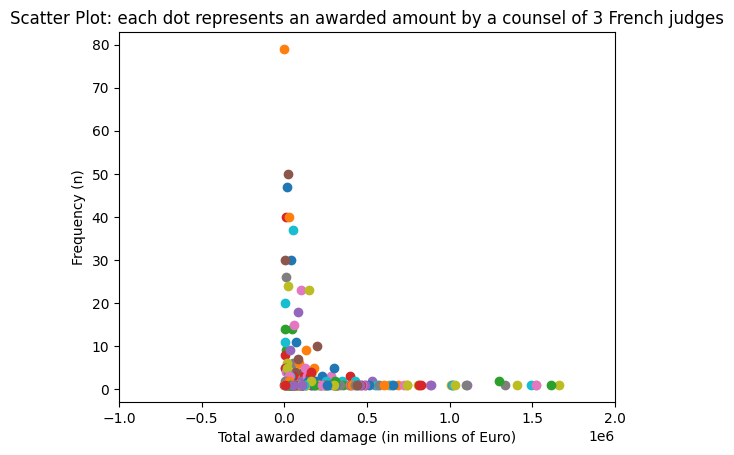

Freedman–Diaconis number of bins: 1520


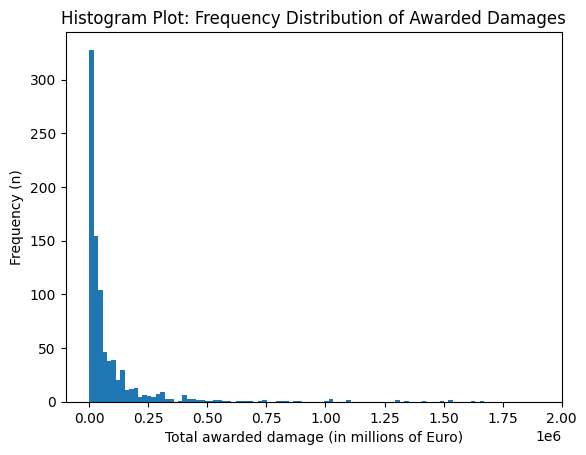

In [39]:
# damages awarded - general

def damages(df_final):
    """
    1. frequency distro, non-bin and bin
    2. per counsel, min-max-means
    3. diff per instance, or paris vs. not paris
    """
    l_dam = list(df_final.damages_tot)
    d_dam = dict(Counter(l_dam))

    '''
    df = pd.DataFrame({
        'damages_tot' : list(d_dam.keys()),
        'frequency' : list(d_dam.values()),
    })
    '''

    for d in d_dam.items():
        k,v = d
        plt.scatter(k,v)
    # plt.xlim(-2000000, 5000000)
    plt.xlim(-1000000, 2000000)
    plt.title('Scatter Plot: each dot represents an awarded amount by a counsel of 3 French judges')
    plt.ylabel("Frequency (n)")
    plt.xlabel("Total awarded damage (in millions of Euro)")
    plt.show()

    l_dam = np.array(l_dam)

    '''
    df_final['damages_tot_re'] = pd.cut(df_final['damages_tot']
                                 ,100)
                                 # ,labels=['Very Low', 'Low', 'Medium'
                                           # ,'High', 'Very High'])
    l_dam = list(df_final.damages_tot_re)
    '''
    l_dam = np.array(l_dam)

    # ALL
    # get bin #
    q25, q75 = np.percentile(l_dam, [25, 75])
    bin_width = 2 * (q75 - q25) * len(l_dam) ** (-1/3)
    bins = round((l_dam.max() - l_dam.min()) / bin_width)
    print("Freedman–Diaconis number of bins:", bins)
    plt.hist(l_dam, bins=bins-10)
    plt.title('Histogram Plot: Frequency Distribution of Awarded Damages')
    plt.ylabel("Frequency (n)")
    plt.xlabel("Total awarded damage (in millions of Euro)")
    plt.xlim(-100000, 2000000)
    plt.show()

    # ABOVE 500,000
    '''
    kwargs = dict(alpha=0.3, bins=20)
    plt.hist(l_dam, **kwargs, color='r', label='total damages')
    # plt.hist(l_dam, color='g', label='total damages')
    # plt.hist(x, density=True, bins=30)
    plt.gca().set(title='Frequency Histogram of infringement total damages', ylabel='Frequency')
    # plt.xlim(50,75)
    # plt.legend();
    plt.show()
    '''

    # PER LAWYER

damages(df_final)


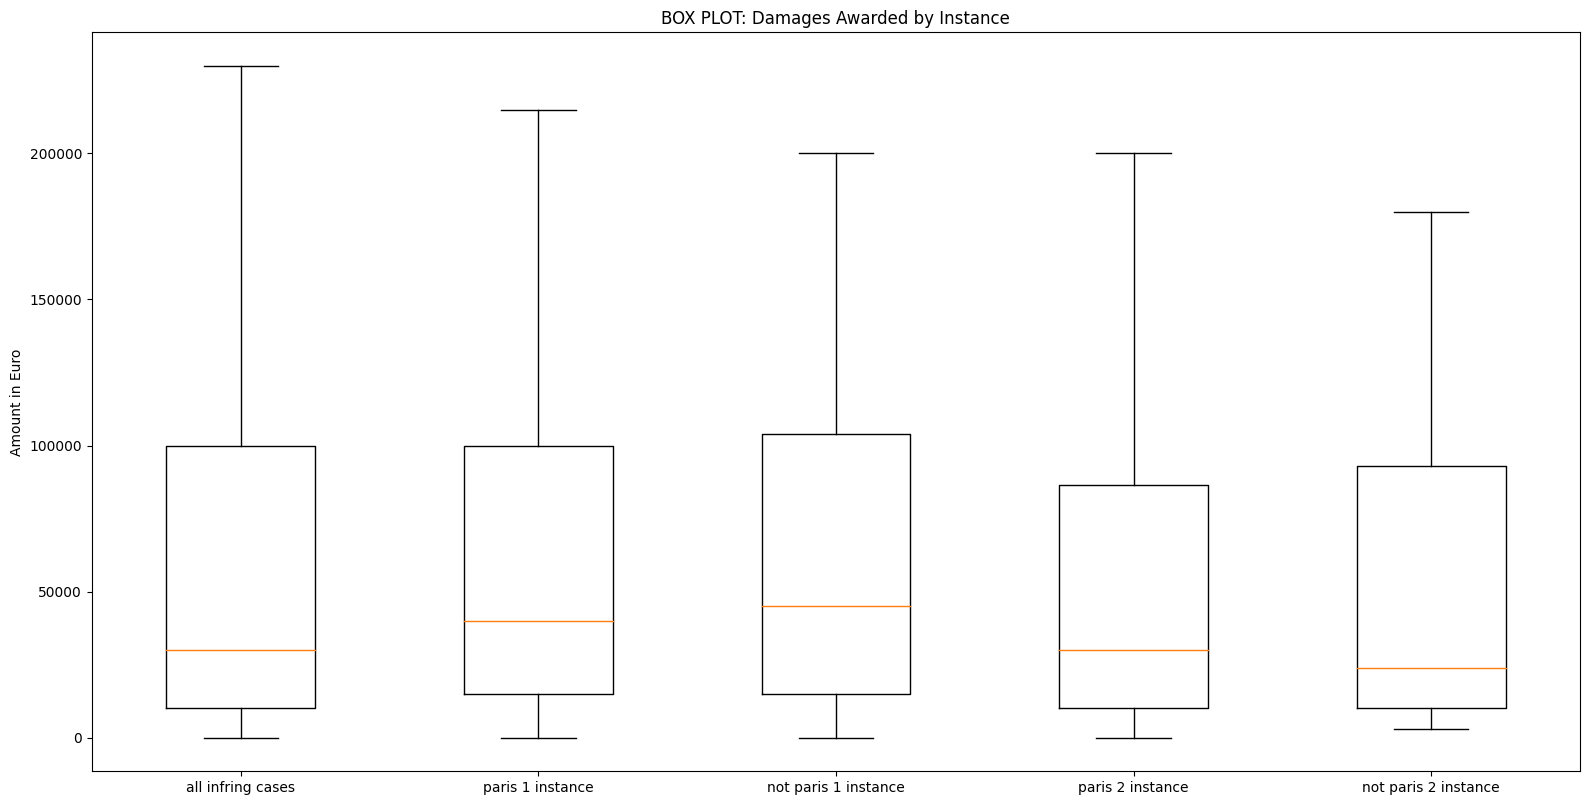

1728806312311.211 35613669439864.72 0.04854333573321834
Ttest_indResult(statistic=-3.255313093646874, pvalue=0.0012055774315962921)
143806338340.16458 10001321329.730408 14.378733929153837
Ttest_indResult(statistic=1.9282227905433433, pvalue=0.055545000697608274)


In [43]:
# comparing damages awarded

def comparing_damages():
    """
    justification for doing a all instances paris vs not paris because of borderliner sig. second inst.
    """

    d_target = {}
    d_target['all infring cases'] = list(df_final['damages_tot'])

    # all instance paris
    # all instance not paris

    d_target['paris 1 instance'] = list(df_final[df_final['first_instance_re_2']=='PARIS'].reset_index(drop=True)['damages_tot'])
    d_target['not paris 1 instance'] = list(df_final[df_final['first_not_paris']==1].reset_index(drop=True)['damages_tot'])
    d_target['paris 2 instance'] = list(df_final[df_final['second_instance_re_2']=='PARIS'].reset_index(drop=True)['damages_tot'])
    d_target['not paris 2 instance'] = list(df_final[df_final['second_not_paris']==1].reset_index(drop=True)['damages_tot'])

    fig, ax = plt.subplots()
    # ax.boxplot(d_target.values(), 0, 'gD')
    ax.boxplot(d_target.values(), 0, '')
    ax.set_xticklabels(d_target.keys())
    plt.title('BOX PLOT: Damages Awarded by Instance')
    plt.ylabel('Amount in Euro')
    resize_plot(3, 2)
    plt.show()

    # perform t-test
    import scipy.stats as stats

    paris_1 = np.array(d_target['paris 1 instance'])
    paris_n1 = np.array(d_target['not paris 1 instance'])
    print(np.var(paris_1), np.var(paris_n1), np.var(paris_1)/np.var(paris_n1))

    # Perform the two sample t-test with equal variances
    pprint(stats.ttest_ind(a=paris_1, b=paris_n1, equal_var=True))
    # pprint(stats.ttest_ind(a=paris_1, b=paris_n1, equal_var=False))

    paris_2 = np.array(d_target['paris 2 instance'])
    paris_n2 = np.array(d_target['not paris 2 instance'])
    print(np.var(paris_2), np.var(paris_n2), np.var(paris_2)/np.var(paris_n2))

    # Perform the two sample t-test with equal variances
    # pprint(stats.ttest_ind(a=paris_2, b=paris_n2, equal_var=True))
    pprint(stats.ttest_ind(a=paris_2, b=paris_n2, equal_var=False))

comparing_damages()

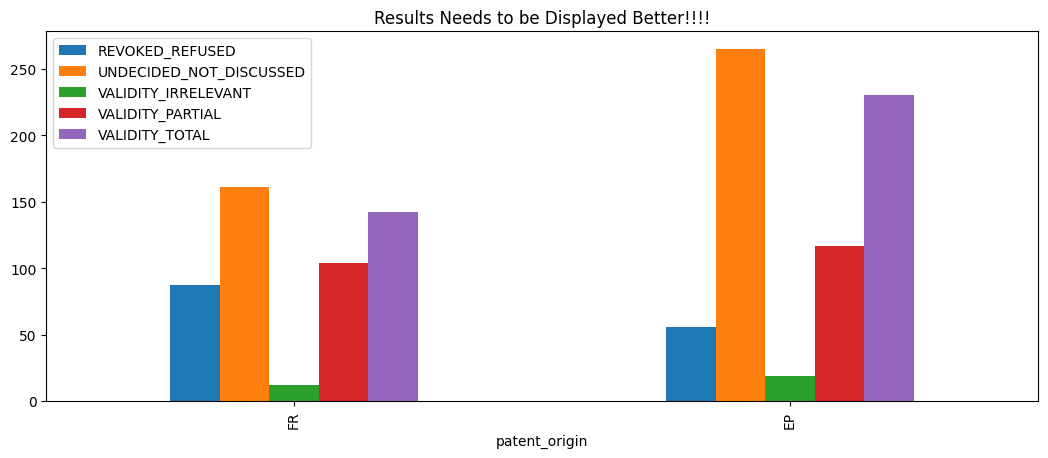

In [46]:
# cross: decisions by patent origin 

def decis_patent():
    """
    """

    # fix errors
    for i in range(1,6):
        df_final[f'pat_{i}_outcome'] = df_final[f'pat_{i}_outcome'].replace(['VALIDITY TOTAL'], 'VALIDITY_TOTAL')
        df_final[f'pat_{i}_outcome'] = df_final[f'pat_{i}_outcome'].replace(['VALIDTY_IREELEVANT'], 'VALIDITY_IRRELEVANT')

    l_pat_out = []
    for i in range(1,6):
        l_pat_out += list(df_final[f'pat_{i}_outcome'])

    l_pat_out = [x for x in l_pat_out if type(x)==str]
    d_pat_out = Counter(l_pat_out)

    # FR VS EU PATENT FATE
    l_pat_out_zip = []
    for i in range(1,6):
        l_pat_out_zip += list(zip(df_final[f'pat_{i}_outcome'], df_final[f'pat_{i}_uid']))

    l_pat_out_zip = [x for x in l_pat_out_zip if type(x[0])==str]
    l_pat_out_zip = [x for x in l_pat_out_zip if type(x[1])==str]

    # get origins
    origins = list(set([x[1][:2] for x in l_pat_out_zip]))

    d_pat_ori = {}
    for cnt in origins:
        l_ = [x[0] for x in l_pat_out_zip if x[1].startswith(cnt)]
        d_ = dict(Counter(l_))
        d_pat_ori[cnt] = d_

    data = {'patent_origin':['FR', 'EP'],
            'REVOKED_REFUSED':[87, 56],
            'UNDECIDED_NOT_DISCUSSED':[161, 265],
            'VALIDITY_IRRELEVANT':[12, 19],
            'VALIDITY_PARTIAL': [104, 117],
            'VALIDITY_TOTAL':[142, 230]}

    df = pd.DataFrame(data)
    l_col = [x for x in list(df.columns) if x!='patent_origin']

    df.plot(x="patent_origin", y=l_col, kind="bar")
    plt.title('Results Needs to be Displayed Better!!!!')
    resize_plot(2,1)
    plt.show()
    
decis_patent()

'l_law_col: 31'


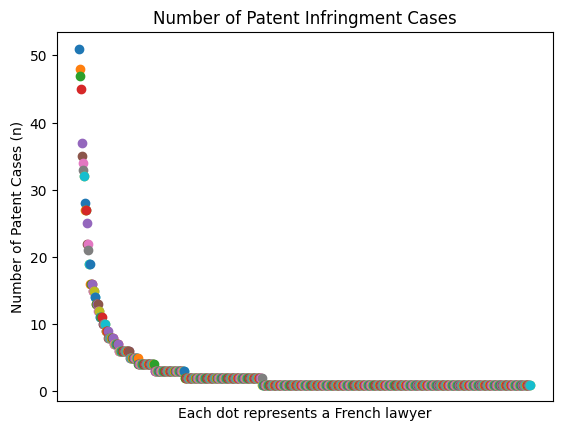

'*** IGNORE THIS OUTPUT - PYTHON JUST LIKE TO BE VERBOSE ***'
{'experience': 3, 'lose': 2, 'win': 1}
{'experience': 27, 'lose': 7, 'win': 20}
{'experience': 51, 'lose': 20, 'win': 31}
{'experience': 37, 'lose': 20, 'win': 17}
{'experience': 1, 'lose': 0, 'win': 1}
{'experience': 32, 'lose': 20, 'win': 12}
{'experience': 3, 'lose': 2, 'win': 1}
{'experience': 6, 'lose': 3, 'win': 3}
{'experience': 34, 'lose': 9, 'win': 25}
{'experience': 2, 'lose': 0, 'win': 2}
{'experience': 1, 'lose': 1, 'win': 0}
{'experience': 1, 'lose': 1, 'win': 0}
{'experience': 13, 'lose': 6, 'win': 7}
{'experience': 10, 'lose': 5, 'win': 5}
{'experience': 10, 'lose': 6, 'win': 4}
{'experience': 15, 'lose': 5, 'win': 10}
{'experience': 7, 'lose': 2, 'win': 5}
{'experience': 2, 'lose': 2, 'win': 0}
{'experience': 16, 'lose': 12, 'win': 4}
{'experience': 1, 'lose': 1, 'win': 0}
{'experience': 2, 'lose': 2, 'win': 0}
{'experience': 1, 'lose': 1, 'win': 0}
{'experience': 15, 'lose': 3, 'win': 12}
{'experience': 22, 

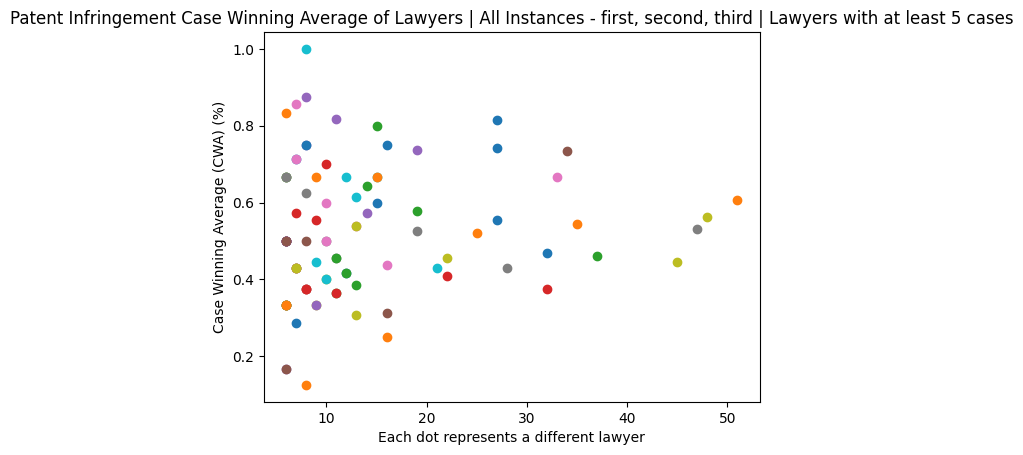

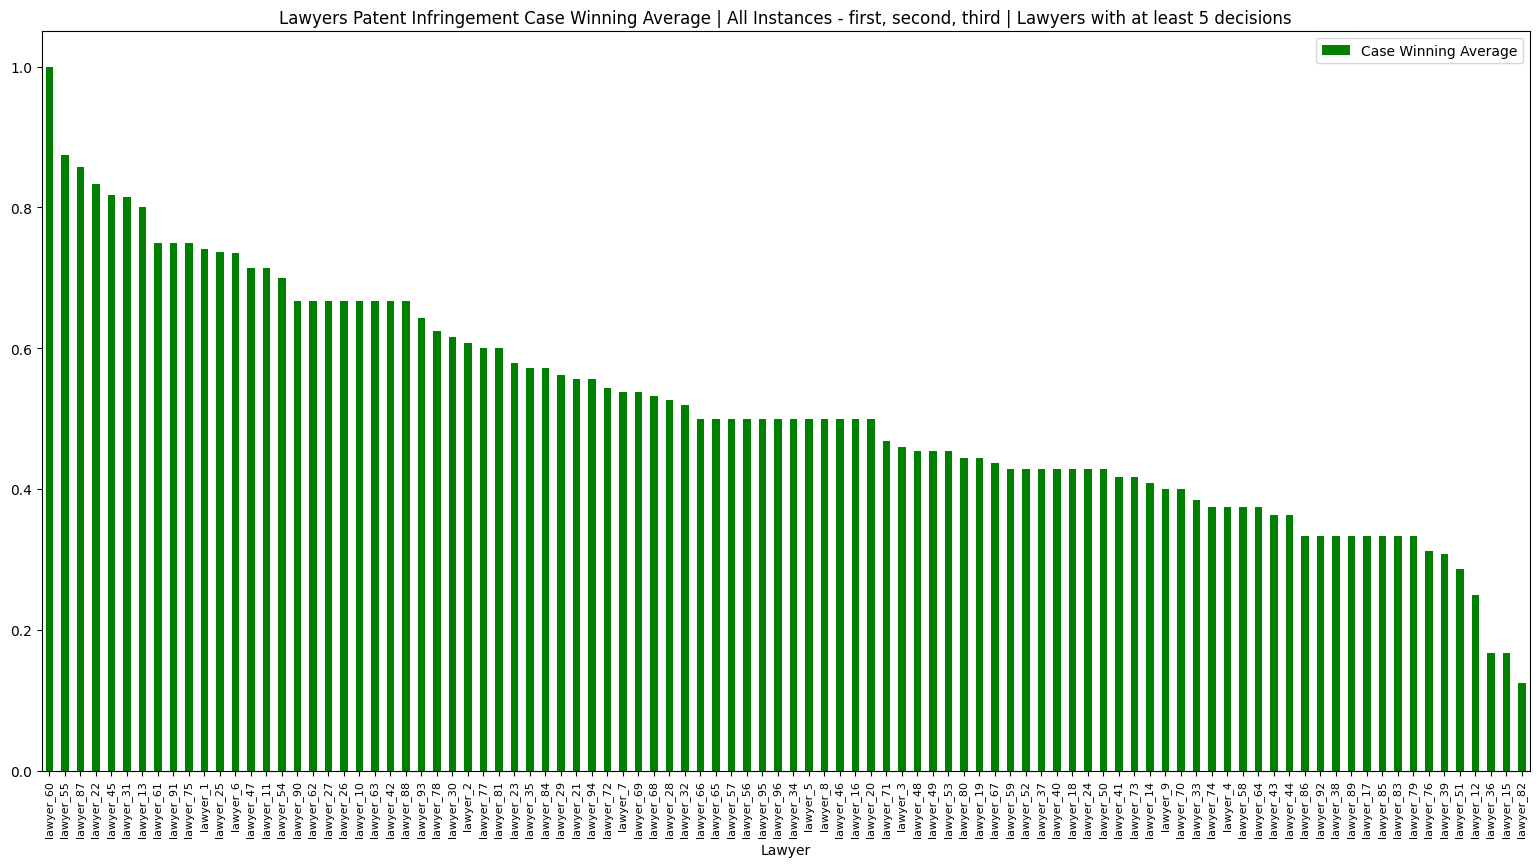

In [49]:
# lawyer descriptive stats

def lawyer_win(df_final, text, cut_off):
    """
    like judges, get individual_lawyer experience
    """

    df_final = fix_lawyer(df_final)

    l_law_col = [x for x in df_final.columns if '_fix' in x]
    l_law_col = [x for x in l_law_col if x!= 'flag_fix']
    pprint("l_law_col: {}".format(len(l_law_col)))

    l_law = []
    for law_col in l_law_col:
        l_law+=list(df_final[law_col])

    l_law = [x for x in l_law if type(x)==str]
    l_law = [x for x in l_law if 'Nobody' not in x]
    l_law = [x for x in l_law if x!='FALSE']

    d_exp_law = Counter(l_law)

    # scatter plot
    l_value = sorted(list(d_exp_law.values()), reverse=True)
    # for x, y in d_exp_judge.items():
    for i, y in enumerate(l_value):
        plt.scatter(i,y)
    plt.xticks([])
    plt.title("Number of Patent Infringment Cases")
    plt.xlabel("Each dot represents a French lawyer")
    plt.ylabel("Number of Patent Cases (n)")
    plt.show()

    pprint('*** IGNORE THIS OUTPUT - PYTHON JUST LIKE TO BE VERBOSE ***')
    # get win average
    d_law_win = {}
    lawyers = list(d_exp_law.keys())
    for law in lawyers:
        loader = {'win':0, 'lose':0, 'experience':d_exp_law[law]}
        for col in l_law_col:
            l_zip = list(zip(df_final['winner_claim_re'], df_final[col]))
            for z in l_zip:
                if z[1] == law:
                    if z[0]==1:
                        if 'claim' in col:
                            loader['win']+=1
                        else:
                            loader['lose']+=1
                    if z[0]==0:
                        if 'claim' in col:
                            loader['lose']+=1
                        else:
                            loader['win']+=1
        d_law_win[law]= loader

    # plot winning average of lawyers
    l_data = []
    for x, y in d_law_win.items():
        pprint(y)
        loser = y['lose']/(y['lose']+y['win'])
        # pprint("loser: {}".format(loser))
        win = y['win']/(y['lose']+y['win'])
        l_data.append([x, win, loser, y['experience']])

    l_data_cut = [x for x in l_data if x[3]>5]

    # scatter plot: experience vs. win rate
    # cut_off = 5
    # l_exp_win = [[x[3], x[1]] for x in l_data]
    l_exp_win = [[x[3], x[1]] for x in l_data if x[3]>cut_off]
    exp = [x[0] for x in l_exp_win]
    win_rate = [x[1] for x in l_exp_win]
    for x,y in list(zip(exp, win_rate)):
        plt.scatter(x, y)
    # plt.scatter(exp, win_rate)
    plt.title(f"Patent Infringement Case Winning Average of Lawyers | {text} | Lawyers with at least {cut_off} cases")
    plt.xlabel("Each dot represents a different lawyer")
    plt.ylabel("Case Winning Average (CWA) (%)")
    plt.show()

    df_out = pd.DataFrame(l_exp_win,
                      columns=['experience', 'win'])
    df_out.to_csv('lawyer_exp_win_5_cutoff.csv', index=False)

    # fit_linear(exp, win_rate, True)

    l_data = [x for x in l_data if x[3]>cut_off]
    data = [x[:2] for x in l_data]
    stan_law = [f'lawyer_{i+1}' for i in range(len(data))]
    data = [[stan_law[i],x[1]] for i,x in enumerate(data)]

    df = pd.DataFrame(data,
                      columns=['Lawyer', 'Case Winning Average'])
    df = df.sort_values(by=['Case Winning Average'], ascending=False)
    df.plot(x='Lawyer', kind='bar', stacked=False, title=f'Lawyers Patent Infringement Case Winning Average | {text} | Lawyers with at least {cut_off} decisions', color=['g'])
    plt.xticks(fontsize=8)
    resize_plot(3, 2)
    plt.show()

    return df_final

def fix_lawyer(df_final):
    """
    'Anne GRAPOTTE BENETREAU': {'experience': 2, 'lose': 1, 'win': 1},
    'Anne GRAPPOTTE BENETREAU': {'experience': 29, 'lose': 15, 'win': 14},

    'Anne LAKITS': {'experience': 1, 'lose': 0, 'win': 1},
    'Anne LAKITS JOSSE': {'experience': 3, 'lose': 1, 'win': 2},

    'Anne-Laure GERIGNY': {'experience': 1, 'lose': 1, 'win': 0},
    'Anne-Laure GERIGNY FRENEAUX': {'experience': 3, 'lose': 1, 'win': 2},

    'Christine JAIS': {'experience': 14, 'lose': 5, 'win': 9},
    'Christine JAIS-MELOT': {'experience': 1, 'lose': 1, 'win': 0},

    'Emmanuel LARARE': {'experience': 1, 'lose': 1, 'win': 0},
    'Emmanuel LARERE': {'experience': 3, 'lose': 1, 'win': 2},

    'Frédérique ETAVENARD': {'experience': 1, 'lose': 1, 'win': 0},
    'Frédérique ETEVENARD': {'experience': 4, 'lose': 1, 'win': 3},

    'Grimaud VALAT': {'experience': 1, 'lose': 1, 'win': 0},
    'Grimaut VALAT': {'experience': 1, 'lose': 0, 'win': 1},

    'Jean-Philippe': {'experience': 1, 'lose': 1, 'win': 0},
    'Jean-Philippe DELSART': {'experience': 10, 'lose': 3, 'win': 7},

    'Laetitia MARCHAND': {'experience': 3, 'lose': 2, 'win': 1},
    'Laetitia MARCHARD': {'experience': 1, 'lose': 1, 'win': 0},

    'Laurence TAZE': {'experience': 1, 'lose': 1, 'win': 0},
    'Laurence TAZE-BERNARD': {'experience': 6, 'lose': 4, 'win': 2},

    'Marie SONNIER': {'experience': 1, 'lose': 1, 'win': 0},
    'Marie SONNIER-POQUILLON': {'experience': 2, 'lose': 0, 'win': 2},

    'Marina C': {'experience': 1, 'lose': 0, 'win': 1},
    'Marina COUSTE': {'experience': 19, 'lose': 9, 'win': 10},

    'Mireille G.': {'experience': 1, 'lose': 1, 'win': 0},
    'Mireille GARNIER': {'experience': 1, 'lose': 1, 'win': 0},

    'PARIS': {'experience': 2, 'lose': 1, 'win': 1},
    'PARIS a ROO': {'experience': 1, 'lose': 0, 'win': 1},
    'PATRICE DE CANDE': {'experience': 1, 'lose': 1, 'win': 0},
    'PIERRE COUSIN': {'experience': 1, 'lose': 1, 'win': 0},
    'PLACEHOLDER': {'experience': 1, 'lose': 0, 'win': 1},

    'Pierre COUSIN': {'experience': 26, 'lose': 12, 'win': 14},
    'Pierre COUSIN ': {'experience': 1, 'lose': 0, 'win': 1},

    'Simon CHRISTIAEN': {'experience': 4, 'lose': 4, 'win': 0},
    'Simon CHRISTIAEN ': {'experience': 1, 'lose': 1, 'win': 0},

    'Thierry MOLLET VIEVILLE': {'experience': 30, 'lose': 17, 'win': 13},
    'Thierry MOLLET-VIEVILLE': {'experience': 7, 'lose': 3, 'win': 4},

    'Vanina VEDEL': {'experience': 2, 'lose': 1, 'win': 1},
    'Vavina VEDEL': {'experience': 1, 'lose': 1, 'win': 0},

    'Yves BIZOLLON': {'experience': 44, 'lose': 24, 'win': 20},
    'Yves BIZOLLON ': {'experience': 1, 'lose': 1, 'win': 0},
    """

    df_final = df_final.replace('Anne GRAPOTTE BENETREAU','Anne GRAPPOTTE BENETREAU', regex=True)
    df_final = df_final.replace('ARNAUD CASALONGA','Arnaud CASALONGA', regex=True)
    df_final = df_final.replace('Anne LAKITS','Anne LAKITS JOSSE', regex=True)
    df_final = df_final.replace('Anne-Laure GERIGNY','Anne-Laure GERIGNY FRENEAUX', regex=True)
    df_final = df_final.replace('Christine JAIS','Christine JAIS-MELOT', regex=True)
    df_final = df_final.replace('Emmanuel LARARE','Emmanuel LARERE', regex=True)
    df_final = df_final.replace('Frédérique ETAVENARD','Frédérique ETEVENARD', regex=True)
    df_final = df_final.replace('Grimaud VALAT', 'Grimaut VALAT', regex=True)
    df_final = df_final.replace('Jean-Philippe', 'Jean-Philippe DELSART', regex=True)
    df_final = df_final.replace('Laurence TAZE', 'Laurence TAZE-BERNARD', regex=True)
    df_final = df_final.replace('Marie SONNIER', 'Marie SONNIER-POQUILLON', regex=True)
    df_final = df_final.replace('Marina C', 'Marina COUSTE', regex=True)
    df_final = df_final.replace('Mireille G.', 'Mireille GARNIER', regex=True)
    df_final = df_final.replace('NOBODY PLACEHOLDER', 'mia', regex=True)
    # df_final = df_final.replace('PARIS', 'Geoffroy GAULTIER', regex=True)
    df_final = df_final.replace('PARIS a ROO', None, regex=True)
    df_final = df_final.replace('PLACEHOLDER', 'mia', regex=True)
    df_final = df_final.replace('PROGENUS', None, regex=True)
    df_final = df_final.replace('Pierre COUSIN ', 'Pierre COUSIN', regex=True)
    df_final = df_final.replace('ROUX', 'Stanislas ROUX-VAILLARD', regex=True)
    df_final = df_final.replace('SHITFUCK', None, regex=True)
    df_final = df_final.replace('Simon CHRISTIAEN ', 'Simon CHRISTIAEN', regex=True)
    df_final = df_final.replace('TCA', None, regex=True)
    df_final = df_final.replace('Thierry MOLLET VIEVILLE', 'Thierry MOLLET-VIEVILLE', regex=True)
    df_final = df_final.replace('VALENCE_Espagne', 'Anne GRAPPOTTE BENETREAU', regex=True)
    df_final = df_final.replace('VILLENEUVE-D ASCQ', None, regex=True)
    df_final = df_final.replace('VILLIERS SUR MARNE', None, regex=True)
    df_final = df_final.replace('Vavina VEDEL', 'Vanina VEDEL', regex=True)
    df_final = df_final.replace('Yves BIZOLLON ', 'Yves BIZOLLON', regex=True)
    df_final = df_final.replace('défaillante', None, regex=True)

    return df_final

df_final = lawyer_win(df_final, 'All Instances - first, second, third', 5)


0.5118309539053782
0.5216035797580779


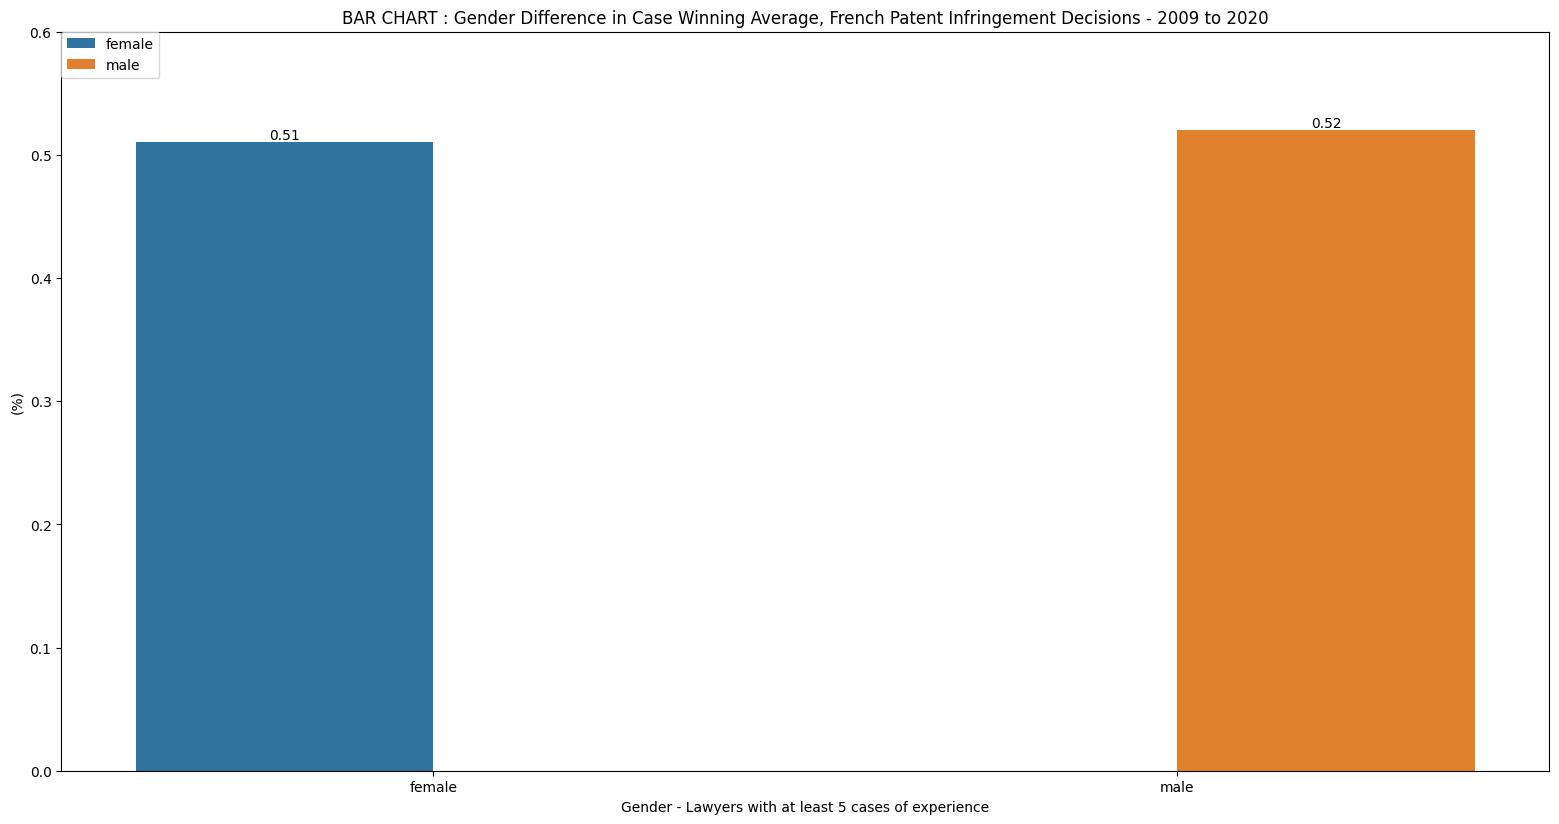

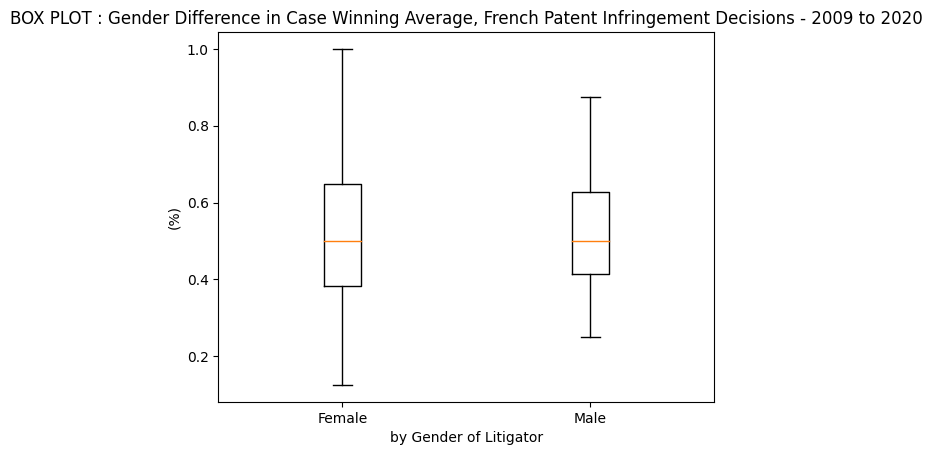

In [50]:
def lawyer_gender():
    """
    """
    from l_top_lawyer_gender import l_top_lawyer

    law_fem = [x[1] for x in l_top_lawyer if x[4]=='female']
    law_mal = [x[1] for x in l_top_lawyer if x[4]=='male']

    pprint(mean(law_fem))
    pprint(mean(law_mal))

    # using seaborn

    l_proportion = [mean(law_fem), mean(law_mal)]
    l_proportion = [float(format(x, '.2f')) for x in l_proportion]

    data = {'Case Winning Average':['female', 'male'],
            'proportion': l_proportion
            }

    df = pd.DataFrame(data)

    ax = sns.barplot(x='Case Winning Average', y='proportion', data=df, hue='Case Winning Average', dodge=True)

    for i in ax.containers:
        ax.bar_label(i,)

    plt.title("BAR CHART : Gender Difference in Case Winning Average, French Patent Infringement Decisions - 2009 to 2020")
    plt.xlabel("Gender - Lawyers with at least 5 cases of experience")
    plt.ylabel("(%)")
    # plt.xticks(rotation=90)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.legend(loc='upper left', borderaxespad=0)
    plt.ylim(0, 0.6)
    resize_plot(3, 2)
    plt.show()

    # box plot

    d_target = {'Female':law_fem, 'Male':law_mal}
    fig, ax = plt.subplots()
    ax.boxplot(d_target.values(), 0, 'gD')
    # ax.boxplot(d_target.values(), 0, '')
    ax.set_xticklabels(d_target.keys())
    plt.title("BOX PLOT : Gender Difference in Case Winning Average, French Patent Infringement Decisions - 2009 to 2020")
    plt.xlabel("by Gender of Litigator")
    plt.ylabel("(%)")
    plt.show()
    
lawyer_gender()


## Data Exploration of Countries of Litigating Parties 

I just started the data viz. Its not quite good.

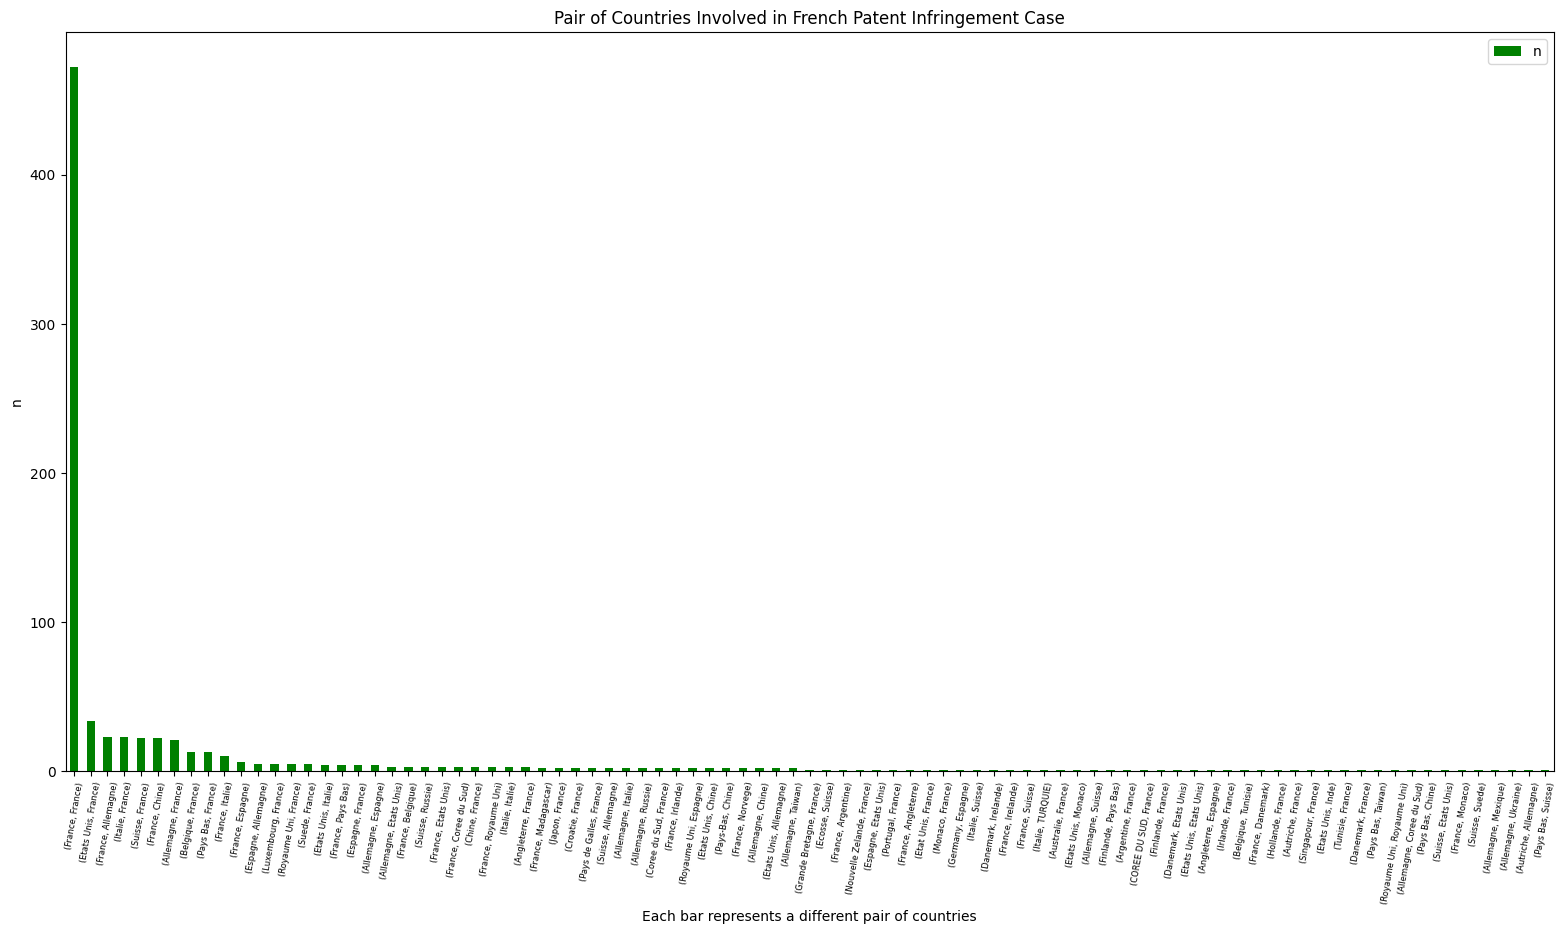

Danmark not found in regex
England not found in regex
Scotland not found in regex
Wale not found in regex
Danmark not found in regex
England not found in regex


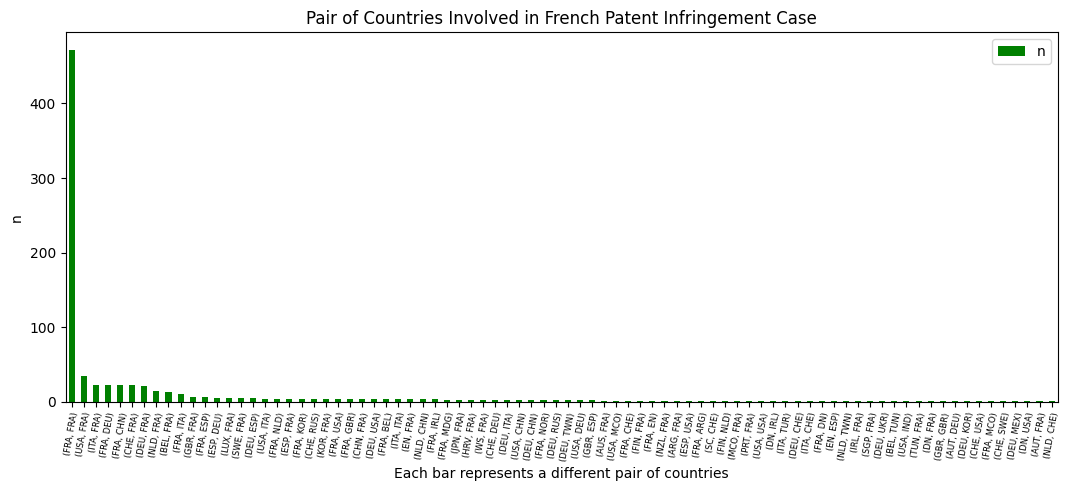

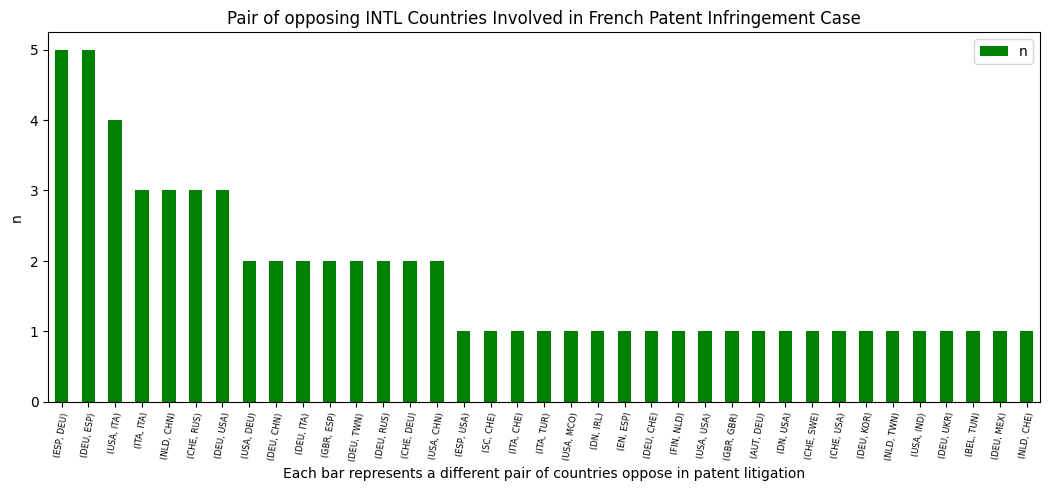

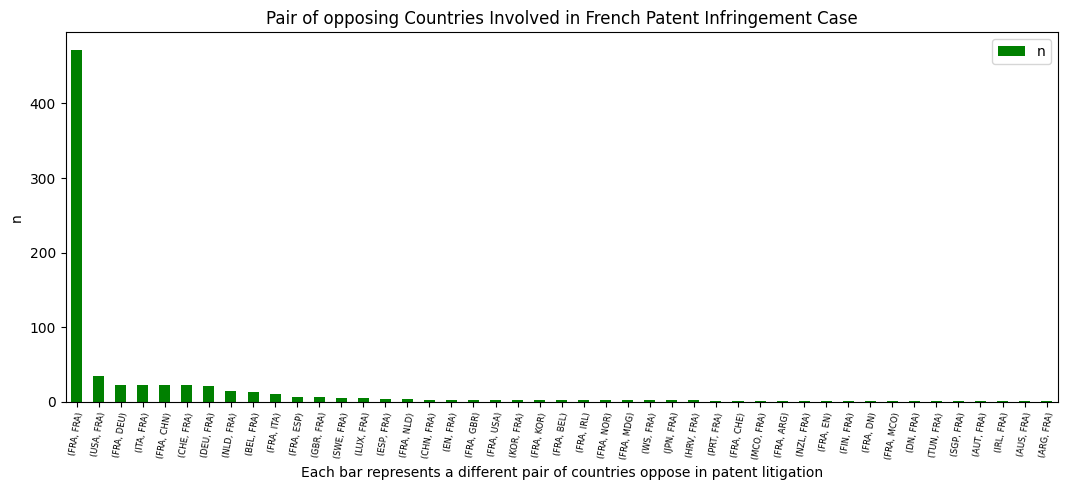

In [53]:
# Countries of Litigating Parties
def cnt_corporation():
    """
    """

    # get census of countries
    census_cnt = []
    census_cnt += list(df_final.claim_geo_loc_1_1_cnt)
    census_cnt += list(df_final.defen_geo_loc_1_1_cnt)
    census_cnt = [x for x in census_cnt if type(x)==str]
    census_cnt = list(set(census_cnt))

    l_pair_cnt = list(zip(df_final.claim_geo_loc_1_1_cnt, df_final.defen_geo_loc_1_1_cnt))

    l_pair_cnt_c = []
    for x in l_pair_cnt:
        flag_out = False
        if type(x[0])!=str:
            flag_out = True
        if type(x[1])!=str:
            flag_out = True
        if flag_out == False:
            l_pair_cnt_c.append(x)

    d_pair_cnt = Counter(l_pair_cnt_c)

    # bar chart
    data = list(zip(list(d_pair_cnt.keys()), list(d_pair_cnt.values())))
    # data = [[stan_ju[i],x[1]] for i,x in enumerate(data)]

    df = pd.DataFrame(data,
                      columns=['claimant-->defendant', 'n'])
    df = df.sort_values(by=['n'], ascending=False)
    df.plot(x='claimant-->defendant', kind='bar', stacked=False, title=f'Pair of Countries Involved in French Patent Infringement Case', color=['g'])
    plt.xlabel("Each bar represents a different pair of countries")
    plt.ylabel("n")
    resize_plot(3, 2)
    plt.xticks(fontsize=6, rotation=80)
    plt.show()

    # STANDARDIZE CNT NAMES

    # get census of countries
    census_cnt = []
    census_cnt += list(df_final.claim_geo_loc_1_1_cnt)
    census_cnt += list(df_final.defen_geo_loc_1_1_cnt)
    census_cnt = [x for x in census_cnt if type(x)==str]
    census_cnt = list(set(census_cnt))

    d_trans = {"Nouvelle Zelande":'New Zealand',
               "Pays de Galles":'Wale',
               "Pays-Bas":'Netherlands',
               "Danemark":'Danmark',
               "Irlande":'Ireland',
               "Irelande":'Ireland',
               "Hollande":'Netherlands',
               "Chine":'China',
               "Tunisie":'Tunisia',
               "Italie":'Italy',
               "Suisse":'Switzerland',
               "Grande Bretagne":'Great Britain',
               "Pays Bas":'Netherlands',
               "Etat Unis":'United States',
               "Royaume Uni":'United Kingdom',
               "United Kingdom":'United Kingdom',
               "Singapour":'Singapore',
               "COREE DU SUD":'South Korea',
               "Coree du Sud":'South Korea',
               "Allemagne":'Germany',
               "Germany":'Germany',
               "Inde":'India',
               "Suede":'Sweden',
               "Croatie":'Croatia',
               "Espagne":'Spain',
               "Norvege":'Norway',
               "Ecosse":'Scotland',
               "Angleterre":'England',
               "Japon":'Japan',
               "Australie":'Australia',
               "Autriche":'Austria',
               "TURQUIE":'Turkey',
               "Belgique":'Belgium',
               "Etats Unis":'United States',
               "Russie":'Russia',
               "France":'France',
               "Luxembourg":'Luxembourg',
               "Mexique":'Mexico',
               "Taiwan":'Taiwan',
               "Ukraine":'Ukraine',
               "Madagascar":'Madagascar',
               "Monaco":'Monaco',
               "Finlande":'Finland',
               "Argentine":'Argentina',
               "Portugal":'Portugal',
              }
    l_pair_cnt_c = [(d_trans[x[0]], d_trans[x[1]]) for x in l_pair_cnt_c]

    # ONE-TIME
    test_trans = lambda x: d_trans[x] if x in list(d_trans.keys()) else x
    census_cnt = [test_trans(x) for x in census_cnt]

    # l_ = list(zip(census_cnt, iso3_codes))

    l_cnt_abb = [('Irelande', 'IRL'),
                 ('New Zealand', 'NZL'),
                 ('Wale', 'WS'),
                 ('Mexique', 'MEX'),
                 ('Holland', 'NL'),
                 ('Danmark', 'DN'),
                 ('Irland', 'IR'),
                 ('Holland', 'NL'),
                 ('China', 'CHN'),
                 ('Tunisia', 'TUN'),
                 ('Argentine', 'ARG'),
                 ('Italy', 'ITA'),
                 ('Switzerland', 'CHE'),
                 ('Great Britain', 'GBR'),
                 ('Holland', 'NL'),
                 ('United States', 'USA'),
                 ('United Kingdom', 'GBR'),
                 ('Singapoure', 'SG'),
                 ('South Korea', 'KOR'),
                 ('South Korea', 'KOR'),
                 ('France', 'FRA'),
                 ('Germany', 'DEU'),
                 ('India', 'IND'),
                 ('Sweden', 'SWE'),
                 ('Germany', 'DEU'),
                 ('Croatia', 'HRV'),
                 ('Spain', 'ESP'),
                 ('Portugal', 'PRT'),
                 ('Norway', 'NOR'),
                 ('Scotland', 'SC'),
                 ('England', 'EN'),
                 ('Japan', 'JPN'),
                 ('Australia', 'AUS'),
                 ('Monaco', 'MCO'),
                 ('Finlande', 'FIN'),
                 ('Luxembourg', 'LUX'),
                 ('Austria', 'AUT'),
                 ('Turkey', 'TUR'),
                 ('Taiwan', 'TWN'),
                 ('Belgium', 'BEL'),
                 ('United States', 'US'),
                 ('United Stares', 'US'),
                 ('Russia', 'RUS'),
                 ('Madagascar', 'MDG'),
                 ('Ukraine', 'UKR'),
                 ('Royaume Uni', 'UK'),
                ]

    d_cnt_abb = {}
    for x in l_cnt_abb:
        d_cnt_abb[x[0]] = x[1]

    # replace 'not found' by original name

    # fix CLAIM
    claim_cnt = [x[0] for x in l_pair_cnt_c]

    iso_claim = get_iso_cnt(claim_cnt)

    temp = list(zip(claim_cnt, iso_claim))
    test_iso = lambda x: (x[0], d_cnt_abb[x[0]]) if x[1]=='not found' else x
    temp = [test_iso(x) for x in temp]

    iso_claim = [x[1] for x in temp]

    # fix DEFEN
    defen_cnt = [x[1] for x in l_pair_cnt_c]

    iso_defen = get_iso_cnt(defen_cnt)

    temp = list(zip(defen_cnt, iso_defen))
    temp = [test_iso(x) for x in temp]

    iso_defen = [x[1] for x in temp]

    l_pair_cnt_c = list(zip(iso_claim, iso_defen))

    d_pair_cnt = Counter(l_pair_cnt_c)

    # bar chart
    data = list(zip(list(d_pair_cnt.keys()), list(d_pair_cnt.values())))
    df = pd.DataFrame(data,
                      columns=['claimant-->defendant', 'n'])
    df = df.sort_values(by=['n'], ascending=False)
    df.plot(x='claimant-->defendant', kind='bar', stacked=False, title=f'Pair of Countries Involved in French Patent Infringement Case', color=['g'])
    plt.xlabel("Each bar represents a different pair of countries")
    plt.ylabel("n")
    resize_plot(2, 1)
    plt.xticks(fontsize=6, rotation=80)
    plt.show()

    # patent infringement litigation between intl parties
    l_pair_int_cnt = [x for x in l_pair_cnt_c if 'FRA' not in x]

    d_pair_int_cnt = Counter(l_pair_int_cnt)

    # bar chart
    data = list(zip(list(d_pair_int_cnt.keys()), list(d_pair_int_cnt.values())))
    df = pd.DataFrame(data,
                      columns=['claimant-->defendant', 'n'])
    df = df.sort_values(by=['n'], ascending=False)
    df.plot(x='claimant-->defendant', kind='bar', stacked=False, title=f'Pair of opposing INTL Countries Involved in French Patent Infringement Case', color=['g'])
    plt.xlabel("Each bar represents a different pair of countries oppose in patent litigation")
    plt.ylabel("n")
    resize_plot(2, 1)
    plt.xticks(fontsize=6, rotation=80)
    plt.show()
    
    # patent infringement litigation between intl parties
    l_pair_int_cnt = [x for x in l_pair_cnt_c if 'FRA' in x]

    d_pair_int_cnt = Counter(l_pair_int_cnt)

    # bar chart
    data = list(zip(list(d_pair_int_cnt.keys()), list(d_pair_int_cnt.values())))
    df = pd.DataFrame(data,
                      columns=['claimant-->defendant', 'n'])
    df = df.sort_values(by=['n'], ascending=False)
    df.plot(x='claimant-->defendant', kind='bar', stacked=False, title=f'Pair of opposing Countries Involved in French Patent Infringement Case', color=['g'])
    plt.xlabel("Each bar represents a different pair of countries oppose in patent litigation")
    plt.ylabel("n")
    resize_plot(2, 1)
    plt.xticks(fontsize=6, rotation=80)
    plt.show()

def get_iso_cnt(l_cnt):
    """
    """
    s_cnt = pd.Series(l_cnt, name='country')
    
    cc = coco.CountryConverter()
    iso_cnt = list(cc.pandas_convert(series=s_cnt, to='ISO3'))

    return iso_cnt

cnt_corporation()


In [12]:
# analyse decisions and assignment dates

df_final = df_final.astype({"assign_year": str, "decisi_year":str})

x = df_final.assign_year.value_counts()
assign_ = x.to_dict(OrderedDict)
assign_year = sorted(list(assign_.keys()))
assign_year.insert(1, '2001')
assign_year.insert(3, '2003')
test_assign = lambda x: assign_[x] if x in list(assign_.keys()) else 0
assign_count = [test_assign(v) for v in assign_year]
print(assign_year)
print(assign_count)
# plt.plot(assign_year[:-1], assign_count[:-1])
# plt.ylabel('year of patent case assignment')
# plt.xlabel('case (n)')
# resize_plot(2,1)
# plt.show()


# CASE DISTRIBUTION PER DATES OF DECISION
l_decision = list(df_final.decisi_year)
decision = df_final.decisi_year.value_counts()
d_decision = dict(decision)
l_year = sorted(d_decision.keys())
l_year = [x for x in l_year if x!='mia']
l_case = [d_decision[k] for k in l_year]

# plt.plot(l_year[:-1], l_case[:-1])
# plt.ylabel('year of decision')
# plt.xlabel('case (n)')
# plt.title('Trend Analysis - French Patent Infringement Cases: 2009-2020')
# resize_plot(2,1)
# plt.show()

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', 'mia']
[3, 0, 3, 0, 3, 10, 16, 58, 56, 80, 87, 71, 65, 55, 57, 68, 50, 38, 13, 6, 160]
